### 阿發智能客服熱點圖 (投信)

1. 會需要能看出時間變化 (由於目前資料較片段，所以請先以月為單位），會希望有三種觀看維度：
   - [`original`] 既有關鍵字: 每日/週/月關鍵字排行榜(實際數量、占比、月成長率）
     - duration
       - `monthly`
       - `weekly`
       - `daily`
     - value_type
       - `count`
       - `percentage`
       - `diff_percentage`
   - [`new`] 新入榜關鍵字: 每日/週/月關鍵字排行榜(實際數量、占比、月成長率）
2. 共現詞排行
   - 例如：點擊關鍵字“信用卡”後，能列舉出與信用卡同時出現的關鍵字，並用文字雲呈現。



In [2]:
from collections import Counter
import datetime as dt
import jionlp as jio
import json
from opencc import OpenCC
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import matplotlib
matplotlib.rcParams['font.family'] = ['Heiti TC']
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline


In [2]:
# report style 設定
plt.style.use('ggplot')
fontproperties = FontProperties(fname='font_ch.ttf')
font = 'font_ch.ttf'
stopword_file_zhTW = 'stopwords_zhTW.txt'

# Initialize drivers
# ws_driver = CkipWordSegmenter(level=3, device=0)
ws = WS('../data/gcs/ckiptagger_data')

# Custom dictionary -> 請窗口提供看看產品字
word_weight = {
    '國泰e家人': 2,
}
custom_dictionary = construct_dictionary(word_weight)
print(custom_dictionary)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

print('Loading Traditional Chinese stopwords...')
stopwords_zhTW = list()
with open(stopword_file_zhTW, 'r', encoding='utf-8') as f:
    for l in tqdm(f.readlines()):
        if not len(l.strip()):
            continue
        stopwords_zhTW.append(l.strip())

stopwords_zhTW += ['想','請問','收到','剛剛']



2022-01-21 10:06:24.095117: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-21 10:06:24.095183: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dst-jupyterlab-01
2022-01-21 10:06:24.095222: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dst-jupyterlab-01
2022-01-21 10:06:24.095492: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2022-01-21 10:06:24.095527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2022-01-21 10:06:24.095535: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2
2022-01-21 10:06:25.792611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CP

[(5, {'國泰e家人': 2.0})]
Loading Traditional Chinese stopwords...


100%|██████████| 2870/2870 [00:00<00:00, 870212.71it/s]


In [ ]:
files = ['../data/gcs/afa_chatbot/CIST/2020/' + path for path in os.listdir('../data/gcs/afa_chatbot/CIST/2020')] + \
        ['../data/gcs/afa_chatbot/CIST/2021/' + path for path in os.listdir('../data/gcs/afa_chatbot/CIST/2021')]

for i in tqdm(range(len(files))):
    if i == 0:
        data = pd.read_excel(files[i], sheet_name='語料處理原版')
        data['file_date'] = files[i].split('/')[-1].split('阿發')[0]
    else:
        tmp = pd.read_excel(files[i], sheet_name='語料處理原版')
        tmp['file_date'] = files[i].split('/')[-1].split('阿發')[0]
        data = pd.concat([
            data, 
            tmp
        ], axis=0)

print(data.shape)
print(data.info())
print(data.head())

data.drop_duplicates().to_csv('chatbot_raw_records_CSIT_20200803_20211101.csv', index=False)


#### 既有關鍵字排行榜 
- 實際數量 (`count`)
- 占比 (`percentage`)
- 月成長率 (`diff_percentage`)

In [3]:
def word_segment(sent_list, tool='ckiptagger', stopwords=stopwords_zhTW):
    ws_nostopwords = list()
    if tool == 'ckip-transformers':
        word_list = ws_driver([sent_list], use_delim=True)
    elif tool == 'ckiptagger':
        word_list = ws(sent_list, coerce_dictionary=custom_dictionary)
    else:
        print('Please specify which word segmentation you want to use')

    for wl in tqdm(word_list):
        ws_nostopwords.append([w for w in wl if w not in stopwords])
    del word_list
    return ws_nostopwords
    
    
def phrase_extractor(sent, stopwords=stopwords_zhTW):
    tw2sp = OpenCC('tw2sp')
    s2twp = OpenCC('s2twp')
    key_phrases = jio.keyphrase.extract_keyphrase(tw2sp.convert(sent))
    key_phrases = [s2twp.convert(kw) for kw in key_phrases]
    key_phrases = [phrase for phrase in key_phrases if phrase not in stopwords]
    return key_phrases


def week_text(x):
    if (x > 53):
        year = 2021
        x = x - 53
    else:
        year = 2020
    
    start = dt.datetime.strftime(dt.datetime.strptime(f"{year}-W{x}-1", "%Y-W%W-%w"), "%Y%m%d")
    end = dt.datetime.strftime(dt.datetime.strptime(f"{year}-W{x}-0", "%Y-W%W-%w"), "%Y%m%d")
        
    return f"{start}-{end}"


In [5]:
df = pd.read_csv('chatbot_raw_records_CSIT_20200803_20211101.csv')
df


,session_id,問法,總機_意圖,總機_信心值,服務台_意圖,服務台_信心值,FAQ_編號,FAQ_信心值,閒聊FAQ_編號,閒聊FAQ_信心值,部門_意圖,部門_信心值,部門_實體,子部門_意圖,子部門_信心值,子部門_實體,處理結果,單一問句,出現次數,問句字數,子部門_意圖(新),子部門_信心值(新),處理結果(新),命中/最接近的FAQ題目,命中/最接近的FAQ答案,處理是否正確,是否需調整,處理方法,處理人,處理方法說明,目標處理結果,file_date,目標處理 FAQ ID,FAQ_標準問法,Unnamed: 24,阿發猜什麼,訊息時間,輸入類型,對話類型,子部門2_意圖,子部門2_信心值,子部門2_實體
0,tp0kuaase4pvu7qadefy,保管費,基金,0.32217014976642555,查詢,0.29266425761366227,127.0,0.28506453303665097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),保管費,1.0,3.0,NaN,NaN,完全聽不懂,ID_127: 買回基金會有什麼費用？,當你透過國泰投信買回基金時，不會收取任何買回費用，但會扣掉保管銀行匯款至受益人指定帳戶時銀行...,未選擇,未選擇,未選擇,未選擇,NaN,NaN,20200803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tp0m3od1evgx2iv5z8r0,證券,基金,0.37260376910311915,查詢,0.2815054459159598,213.0,0.5093489761574914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),證券,1.0,2.0,NaN,NaN,完全聽不懂,ID_213: 投信申購與銀行申購有何不同,"你可以參考""投資需求""與""交易便利性""作選擇，國泰季主推基金<a href=""https:/...",未選擇,未選擇,未選擇,未選擇,NaN,NaN,20200803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tpl2arwotr9p92qwjbeq,線上專員,真人服務,0.36197723584666247,查詢,0.3320416031736389,50.0,0.5500720357572021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),線上專員,1.0,4.0,NaN,NaN,完全聽不懂,ID_50: 申請成為國泰e家人有無任何資格限制？,不論你是本國籍或外國籍、自然人或法人，甚至於未成年人，都可以用約定申購人本人的銀行帳戶申請開...,未選擇,未選擇,未選擇,未選擇,NaN,NaN,20200803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tpqlqzt0dc39jbqzcvgk,年報,基金,0.2946257988293196,查詢,0.3247868422440431,210.0,0.31825731448642125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),年報,1.0,2.0,NaN,NaN,完全聽不懂,ID_210: 績效表現,"請參考國泰系列基金資訊 <a href=""https://www.cathaysite.co...",未選擇,未選擇,未選擇,未選擇,NaN,NaN,20200803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tp0vib68zjhmu5jvamen,昨天發生什麼事,Hello,0.4139326840769279,推薦,0.34586068768539163,30.0,0.43680031821789156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),昨天發生什麼事,1.0,7.0,NaN,NaN,完全聽不懂,ID_30: 定時定額扣款失敗停扣,基金停扣是指一筆契約連續三個月扣款失敗(即為三次)，就會自動終止扣款。<br>\n若要恢復扣...,未選擇,未選擇,未選擇,未選擇,NaN,NaN,20200803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10969,20211101-103146-0_00294,有扣款 為什麼沒庫存,基金,0.300949808064089,補發,0.406914636535888,286.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:命中FAQ),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211101,NaN,扣款後單位數何時入帳,NaN,NaN,2021-11-01 10:38:02,1.0,customerMsg,NaN,NaN,NaN
10970,20211101-103146-0_00295,有證券戶沒辦法直接購買基金嗎？,基金,0.827088299021015,申購,0.488747470710558,7.0,0.512553261761412,NaN,NaN,申購,0.392261089489235,NaN,NaN,NaN,NaN,(state:基金_操作 反問),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211101,NaN,NaN,NaN,NaN,2021-11-01 10:38:04,1.0,customerMsg,NaN,NaN,NaN
10971,20211101-103146-0_00296,有證卷開戶還要重新開戶嗎,開戶,0.959885728050488,查詢,0.890245178440478,201.0,0.737658114170594,NaN,NaN,查詢_申請進度,0.717363633512524,NaN,NaN,NaN,NaN,"(state:操作nlu處理,bot=開戶)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211101,NaN,NaN,NaN,NaN,2021-11-01 10:38:03,1.0,customerMsg,NaN,NaN,NaN
10972,20211101-103146-0_00297,有配息嗎？,基金,0.917285435493545,查詢,0.623732681935554,34.0,0.839685039046236,NaN,NaN,查詢,0.975039907620716,NaN,配息,0.907033062999025,NaN,"(state:項目nlu處理,bot=基金)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211101,NaN,NaN,NaN,NaN,2021-11-01 10:38:03,1.0,customerMsg,NaN,NaN,NaN


In [64]:
sent_list = df['問法'].values.tolist()
word_list = word_segment(sent_list = [str(sent) for sent in sent_list], tool='ckiptagger', stopwords=stopwords_zhTW)
phrase_list = list()
for sent in tqdm(sent_list):
    phrase_list.append(phrase_extractor(str(sent)))


100%|██████████| 10974/10974 [07:52<00:00, 23.22it/s]


In [74]:
# df['keyword'] = word_list
# df['keyword'] = df['keyword'].apply(lambda x: ','.join(x))
# df['phrase'] = phrase_list
# df['phrase'] = df['phrase'].apply(lambda x: ','.join(x))
# df['month'] = df['file_date'].apply(lambda x: str(x)[:6])
# df['weekOfYear'] = df['file_date'].apply(lambda x: dt.datetime.strptime(str(x), '%Y%m%d').isocalendar()[1] + 53 * (dt.datetime.strptime(str(x), '%Y%m%d').isocalendar()[0]-2020))
# df['weekOfYear'] = df['weekOfYear'].apply(lambda x: week_text(x))
# df = df[df['問法'].notnull()]
# new_columns = df.columns.tolist()[:2] + df.columns.tolist()[-4:] + [df.columns.tolist()[-15]] + df.columns.tolist()[2:-15] + df.columns.tolist()[-14:-4]
# df = df[new_columns]
# df = df.rename(columns={'keyword': '斷詞結果', 'phrase': '關鍵短語抽取結果'})
# df.to_csv('external_output/afa_chatbot_records-CSIT-20200803_20211101.csv', index=False)
# df



,session_id,問法,斷詞結果,關鍵短語抽取結果,month,weekOfYear,file_date,總機_意圖,總機_信心值,服務台_意圖,服務台_信心值,FAQ_編號,FAQ_信心值,閒聊FAQ_編號,閒聊FAQ_信心值,部門_意圖,部門_信心值,部門_實體,子部門_意圖,子部門_信心值,子部門_實體,處理結果,單一問句,出現次數,問句字數,子部門_意圖(新),子部門_信心值(新),處理結果(新),命中/最接近的FAQ題目,命中/最接近的FAQ答案,處理是否正確,是否需調整,處理方法,處理人,處理方法說明,目標處理結果,目標處理 FAQ ID,FAQ_標準問法,Unnamed: 24,阿發猜什麼,訊息時間,輸入類型,對話類型,子部門2_意圖,子部門2_信心值,子部門2_實體
0,tp0kuaase4pvu7qadefy,保管費,保管費,保管費,202008,20210809-20210815,20200803,基金,0.32217014976642555,查詢,0.29266425761366227,127.0,0.28506453303665097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),保管費,1.0,3.0,NaN,NaN,完全聽不懂,ID_127: 買回基金會有什麼費用？,當你透過國泰投信買回基金時，不會收取任何買回費用，但會扣掉保管銀行匯款至受益人指定帳戶時銀行...,未選擇,未選擇,未選擇,未選擇,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tp0m3od1evgx2iv5z8r0,證券,證券,證券,202008,20210809-20210815,20200803,基金,0.37260376910311915,查詢,0.2815054459159598,213.0,0.5093489761574914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),證券,1.0,2.0,NaN,NaN,完全聽不懂,ID_213: 投信申購與銀行申購有何不同,"你可以參考""投資需求""與""交易便利性""作選擇，國泰季主推基金<a href=""https:/...",未選擇,未選擇,未選擇,未選擇,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tpl2arwotr9p92qwjbeq,線上專員,"線上,專員",線上專員,202008,20210809-20210815,20200803,真人服務,0.36197723584666247,查詢,0.3320416031736389,50.0,0.5500720357572021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),線上專員,1.0,4.0,NaN,NaN,完全聽不懂,ID_50: 申請成為國泰e家人有無任何資格限制？,不論你是本國籍或外國籍、自然人或法人，甚至於未成年人，都可以用約定申購人本人的銀行帳戶申請開...,未選擇,未選擇,未選擇,未選擇,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tpqlqzt0dc39jbqzcvgk,年報,年報,年報,202008,20210809-20210815,20200803,基金,0.2946257988293196,查詢,0.3247868422440431,210.0,0.31825731448642125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),年報,1.0,2.0,NaN,NaN,完全聽不懂,ID_210: 績效表現,"請參考國泰系列基金資訊 <a href=""https://www.cathaysite.co...",未選擇,未選擇,未選擇,未選擇,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tp0vib68zjhmu5jvamen,昨天發生什麼事,"昨天,發生,事",事,202008,20210809-20210815,20200803,Hello,0.4139326840769279,推薦,0.34586068768539163,30.0,0.43680031821789156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:完全聽不懂),昨天發生什麼事,1.0,7.0,NaN,NaN,完全聽不懂,ID_30: 定時定額扣款失敗停扣,基金停扣是指一筆契約連續三個月扣款失敗(即為三次)，就會自動終止扣款。<br>\n若要恢復扣...,未選擇,未選擇,未選擇,未選擇,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10969,20211101-103146-0_00294,有扣款 為什麼沒庫存,"扣款, ,庫存",扣款,202111,20221031-20221106,20211101,基金,0.300949808064089,補發,0.406914636535888,286.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:命中FAQ),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,扣款後單位數何時入帳,NaN,NaN,2021-11-01 10:38:02,1.0,customerMsg,NaN,NaN,NaN
10970,20211101-103146-0_00295,有證券戶沒辦法直接購買基金嗎？,"證券戶,沒辦法,購買,基金","證券戶沒辦法,基金",202111,20221031-20221106,20211101,基金,0.827088299021015,申購,0.488747470710558,7.0,0.512553261761412,NaN,NaN,申購,0.392261089489235,NaN,NaN,NaN,NaN,(state:基金_操作 反問),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-01 10:38:04,1.0,customerMsg,NaN,NaN,NaN
10971,20211101-103146-0_00296,有證卷開戶還要重新開戶嗎,"證卷,開戶,開戶",證卷開戶,202111,20221031-20221106,20211101,開戶,0.959885728050488,查詢,0.890245178440478,201.0,0.737658114170594,NaN,NaN,查詢_申請進度,0.717363633512524,NaN,NaN,NaN,NaN,"(state:操作nlu處理,bot=開戶)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-01 10:38:03,1.0,customerMsg,NaN,NaN,NaN
10972,20211101-103146-0_00297,有配息嗎？,配息,配息,202111,20221031-20221106,20211101,基金,0.917285435493545,查詢,0.623732681935554,34.0,0.839685039046236,NaN,NaN,查詢,0.975039907620716,NaN,配息,0.907033062999025,NaN,"(state:項目nlu處理,bot=基金)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-01 10:38:03,1.0,customerMsg,NaN,NaN,NaN


In [6]:
df = pd.read_csv('chatbot_raw_records_CSIT_20200803_20211101.csv')
tmp_df = df.session_id.value_counts().reset_index()
tmp_df[tmp_df['session_id']>1]

df[df['session_id']=='tpn95qpu61kgmh2fhmtn']


,index,session_id
0,tp7urxp2005jqniekmr1,7
1,tpakjufmiidb5wavd93f,5
2,tpzqrkpu9dgxue2zqod7,4
3,tpbargrf5i1g12vfkbvo,4
4,tp0m3od1evgx2iv5z8r0,4
...,...,...
298,tpmc47w601z6m20oea0g,2
299,tpn95qpu61kgmh2fhmtn,2
300,tp5s1y3cfzp5qfzpq23d,2
301,tpy06j0ytz85k0vvnjfg,2


,session_id,問法,總機_意圖,總機_信心值,服務台_意圖,服務台_信心值,FAQ_編號,FAQ_信心值,閒聊FAQ_編號,閒聊FAQ_信心值,部門_意圖,部門_信心值,部門_實體,子部門_意圖,子部門_信心值,子部門_實體,處理結果,單一問句,出現次數,問句字數,子部門_意圖(新),子部門_信心值(新),處理結果(新),命中/最接近的FAQ題目,命中/最接近的FAQ答案,處理是否正確,是否需調整,處理方法,處理人,處理方法說明,目標處理結果,file_date,目標處理 FAQ ID,FAQ_標準問法,Unnamed: 24,阿發猜什麼,訊息時間,輸入類型,對話類型,子部門2_意圖,子部門2_信心值,子部門2_實體
55,tpn95qpu61kgmh2fhmtn,koko網銀可以用來辦國泰投信的帳戶嗎?,帳務,0.48879722543918636,查詢,0.5645083550276164,55.0,0.44811322652796204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(state:服務台反問),koko網銀可以用來辦國泰投信的帳戶嗎?,1.0,20.0,NaN,NaN,服務台反問查詢,ID_55: 國泰e家人可以約定的銀行帳戶？,「國泰e家人」電子交易可約定之轉帳授權帳戶，必需要是全國性繳費作業配合之銀行。可約定之轉帳授...,未選擇,未選擇,未選擇,未選擇,NaN,NaN,20200803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,tpn95qpu61kgmh2fhmtn,請問線上開投信的戶頭,開戶,0.6824058574443874,查詢,0.7171642351640827,50.0,0.48781564287551954,NaN,NaN,查詢_申請進度,0.801951879002698,NaN,NaN,NaN,NaN,"(state:操作nlu處理,bot=開戶)",請問線上開投信的戶頭,1.0,10.0,NaN,NaN,開戶查詢_申請進度,ID_50: 申請成為國泰e家人有無任何資格限制？,不論你是本國籍或外國籍、自然人或法人，甚至於未成年人，都可以用約定申購人本人的銀行帳戶申請開...,未選擇,未選擇,未選擇,未選擇,NaN,NaN,20200803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df = pd.read_csv('chatbot_keyword_phrase_timesplit.csv')
df['weekOfYear'] = df['weekOfYear'].apply(lambda x: week_text(x))
# df = df.rename(columns={'keyword': '斷詞結果', 'phrase': '關鍵短語抽取結果'})
# df = df[['file_date','weekOfYear','month','問法','斷詞結果','關鍵短語抽取結果']]
# df.to_csv('external_output/user_asks_total_records-20200803_20211101.csv', index=False)
df


,file_date,問法,keyword,phrase,month,weekOfYear
0,20200803,保管費,保管費,保管費,202008,20210809-20210815
1,20200803,702.0,702.0,NaN,202008,20210809-20210815
2,20200803,買國泰股利精選30,"買,國泰,股利,精選,30",國泰股利,202008,20210809-20210815
3,20200803,國泰股利30,"國泰,股利,30",國泰股利,202008,20210809-20210815
4,20200803,國泰台灣ESG永續高股息ETF基金,"國泰,台灣,ESG,永續,高,股息,ETF,基金","高股息ETF基金,國泰臺灣ESG",202008,20210809-20210815
...,...,...,...,...,...,...
10968,20211101,國泰全球智能電動車ETF基金，只能利用證券戶購買嗎？,"國泰,全球,智能,電動車,ETF,基金,利用,證券戶,購買","國泰全球智慧電動車ETF基金,證券戶",202111,20221031-20221106
10969,20211101,國泰全球基因免疫與醫療革命ETF,"國泰,全球,基因,免疫,醫療,革命,ETF","國泰全球基因免疫,醫療革命ETF",202111,20221031-20221106
10970,20211101,國泰免疫基金,"國泰,免疫,基金",國泰免疫基金,202111,20221031-20221106
10971,20211101,國泰一家人的交易密碼我要去哪裡查,"國泰,一家人,交易,密碼,哪裡,查","國泰一家人,交易密碼",202111,20221031-20221106


In [10]:
kw_col = 'phrase'

df_phrase_stacked = df.drop(kw_col, axis=1).join(df[kw_col]
                                        .str
                                        .split(',', expand=True)
                                        .stack()
                                        .reset_index(drop=True, level=1)
                                        .rename(kw_col))

df_phrase_stacked = df_phrase_stacked.drop(['keyword','問法'], axis=1)
df_phrase_stacked


,file_date,month,weekOfYear,phrase
0,20200803,202008,20210809-20210815,保管費
1,20200803,202008,20210809-20210815,NaN
2,20200803,202008,20210809-20210815,國泰股利
3,20200803,202008,20210809-20210815,國泰股利
4,20200803,202008,20210809-20210815,高股息ETF基金
...,...,...,...,...
10969,20211101,202111,20221031-20221106,醫療革命ETF
10970,20211101,202111,20221031-20221106,國泰免疫基金
10971,20211101,202111,20221031-20221106,國泰一家人
10971,20211101,202111,20221031-20221106,交易密碼


In [11]:
def kw_cleasner(x):
    if not x:
        res = np.nan
    elif type(x) != str:
        res = x
    else:
        dirty_char = ['"','?',',','!']
        for char in dirty_char:
            x = x.replace(char, '').strip()
            
        if len(np.unique(list(x)).tolist()) == 1:
            res = np.nan
        else:
            res = x
    return res

df_phrase_stacked[kw_col] = df_phrase_stacked[kw_col].apply(lambda x: kw_cleasner(x))
df_phrase_stacked = df_phrase_stacked[(df_phrase_stacked[kw_col].notnull()) & (df_phrase_stacked[kw_col] != '')]
df_phrase_stacked

# df = df[~df[kw_col].isin(['"', '%', '--', '0', ''])].reset_index(drop=True)
# sorted(df[kw_col].value_counts().index.tolist())


,file_date,month,weekOfYear,phrase
0,20200803,202008,20210809-20210815,保管費
2,20200803,202008,20210809-20210815,國泰股利
3,20200803,202008,20210809-20210815,國泰股利
4,20200803,202008,20210809-20210815,高股息ETF基金
4,20200803,202008,20210809-20210815,國泰臺灣ESG
...,...,...,...,...
10969,20211101,202111,20221031-20221106,國泰全球基因免疫
10969,20211101,202111,20221031-20221106,醫療革命ETF
10970,20211101,202111,20221031-20221106,國泰免疫基金
10971,20211101,202111,20221031-20221106,國泰一家人


In [107]:
duration_col = 'month'
duration_name = 'monthly'
value_type = 'count'



In [108]:
df_duration = df_phrase_stacked[[duration_col, kw_col]]
df_duration = df_duration.groupby([duration_col, kw_col]).agg({kw_col: 'count'}).rename(columns={kw_col: 'count'})
df_duration_pivot = pd.pivot_table(df_duration, values='count', index=[duration_col], columns=[kw_col], fill_value=0.0)
# df_duration_pivot.to_csv(f'external_output/original/afa_CSIT-pivotTable-{kw_col}-{duration_name}-{value_type}-20200803_20211101.csv')
df_duration_pivot


phrase,%數,00655L,00710B,00793B,00799B,00881下市條件,0手續,0手續費,1-5年美元高收益債券基金,10點,10點L,10點Line,10點LinePoints,16日交易,16點,19號講座,2.5折,2.8折,2029A型別,20號扣款,22號,25日扣款國泰小龍中國,25號,26日扣款,26號,26號基金扣款日,26號扣款,2檔基金,3Q,3點,5F,5G,5G+etf,5GETF,5Getf,5G基礎建設,5G基礎設施基金,5G基金,5G手續費,5倍券,5點,5／13,6號,7天,8號,9/9日扣款,9月30號,9號,A123456789,ABU003,AB方,ACU0008基金,ACU007,AMU054,AP,APP,APP申購基金,AP型別差,AP差別,Act017,Act022,Act041,Al,Android系統,App,A型別,A型別基金,A基金,A等級醫療保健產,A級別,A股,A跟P,A類,Beta值,B型,B型別差別,CBAS,CODE,COVID-19,Code,EBC,EBP,EFT,EMAIL,ESG,ESGETF,ESG基金,ET,ETF,ETF00893,ETF5G,ETF傘型基金,ETF分配通知書,ETF受益人數,ETF受益帳戶,ETF受益通知,ETF商品,ETF基金,ETF基金成分股,ETF基金持股,ETF基金收益分配電子帳單,ETF基金費用,ETF帳,ETF微課程,ETF手續費,ETF扣款金額,ETF收益分配,ETF收益分配資料,ETF收益分配通知單,ETF收益分配通知書,ETF收益通知,ETF數位電子帳單,ETF數字帳單,ETF申購手續費,ETF相關問題,ETF系列基金,ETF紙本受益分配通知單,ETF股利,ETF資料,ETF資產規模,ETF配息匯款帳戶,ETF配息帳號,ETF配息資料,ETF配息通知,ETF配息通知e化申請,ETF電子,ETF電子帳單,ETF電子配息,ETF電子配息帳單,ETF高股息,EVETF,Easy,Easy扣,Email,Esg,Etf,Etf手續費,Etf股利,Etf講座,Etf電子配息,Explorer進行開戶,E存摺,E家人,E家人國泰優禮,E家人申請進度,E家人終身,E家密碼,E收益分配通知書通知書,E櫃檯,E證問卷,GTF,GetF,Gf,Hello,Hello阿發～,Hey,Hi,Hi阿發,How,H股,IG活動,IPO,IPO手續費,I型別,J120792151開戶進度,J檔基金,KD,KOKO,KOKo帳戶,Koko,LINE,LINE點數,LIne5,Line,Line點數,Lin點,M014,MIT,Mail,Mit,NB型,NB型別,Ne,Ok,PC,POINT,POINTS,Pizza,Points,Points點數,P型別,P類差,QR,QRCODE,QRCode,R3,RO-A,RR2,RRE,SQL,TES,TEST,TFWC,Tencent,Thank,Thing,Tks,Tsk,USD,WB21000041,WMF0040803,WTF,X220024196,Yes,a型別,a片,easy扣,e家人,e家人),e家人入口,e家人扣款帳號,e家人會員,e家人申請書,e家人系統,e家人紙本,e家人開戶表格,e家人開戶資料表,e家人開戶進度,e家仁,i'm,p型別,r型別,{民,※國泰,一家人,一家人帳戶,一家人才能,一家人申請書,一家銀行,一欄位,一覽表,三商巧福牛肉麵,三檔,三重湯城,上市日期,上市時間,上市櫃公司,上櫃,上班時間,下單,...,都會,配息,配息B投資標的多久會,配息來源,配息內容,配息基金,配息基金配息,配息帳,配息帳單,配息帳戶,配息帳號,配息收款銀行,配息日期,配息時程,配息時間,配息款,配息狀況,配息率,配息總額,配息通知,配息通知書,配日,配錢,醫療,醫療ETF,醫療革命ETF,重大事件,金AI,金屬性,金控,金控員工手續費優惠,金融,金融博覽,金融博覽會,金融友善服務,金融科技展,金錢,金額,金額投資,金額高中,銀行,銀行分局,銀行匯費,銀行存款,銀行帳戶,銀行帳號,銀行戶頭,銀行扣款密碼,銀行扣款時間,銀行扣繳帳戶,銀行申請書,銀行餘額,銷售機構,銷戶,錢單筆,錯誤,錯誤程式碼E001,鑽會,鑽會扣款,鑽石卡,門檻,閈戶,開戶,開戶問題,開戶情況,開戶手機號碼,開戶時間,開戶狀況,開戶申請書,開戶申請進度,開戶網站,開戶線上核印,開戶證券,開戶證卷商,開戶資料,開戶進度,開戶電話號碼錯誤,開線,開通密碼,關係,關鍵字,阿姨,阿松,阿發,阿發乾,阿發功能,阿發基金,阿發密碼,阿發市馬鈴薯,阿發技能大富翁活動辦法,阿發投資技能,阿發投資趨勢,阿發投資趨勢技能,阿發早安,阿發週年,阿發阿發,阿發顏色,阿花,陸港股,階梯,隔天,隨身基金,隱私權政策,集保,集保e,集保存摺,集保帳戶,集保帳號,集保戶,集團,集團員工,集團員工下單,集團滿意度,集帳戶,集點,雙G組合,零手續費,電動車,電動車ETF,電動車ETF基金,電動車ETF手續費,電動車ETF申購方式,電動車IPO,電動車扣款帳號,電動車淨值,電動車相關類股,電子,電子E化送line點數5,電子一家人,電子下單,電子下單手續費,電子交易,電子交易扣款帳戶,電子交易指定扣款帳戶,電子交易系統,電子交易系統都會,電子交易約定帳戶,電子交易約定書,電子交易額度,電子信,電子信箱,電子分配通知書,電子單據,電子報,電子帳,電子帳單,電子帳單ETF,電子帳單活動,電子帳單簡訊,電子申請書,電子申購,電子通知,電子通知書,電子郵件,電子郵件信箱,電子郵件收益分配通知書,電子郵箱,電子配息,電子配息會,電子配息通知,電子配息郵件,電腦,電腦客服,電腦板,電腦版,電腦版基金資料,電話,電話客服服務時間,電話照會,電話號碼,電話資料,靈活智慧,靈活智淨値,非國泰世華客戶,非國泰帳戶,非國泰證券,頁面,順位淨值,順位資產抵押債會,順利扣款,順延,須要,預約,額度,顏色,類似世礦基金,類全委,類別單筆,風險,風險分數,風險屬性,風險屬性問券,風險屬性問卷,風險承受度,風險等級定義,風險評估,風險評估分析,風險評估表,飆股,飆股基金,食品股,食品股基金,食品類股基金,餘額,首頁,香港,馬來西亞,馬產生器,馬鈴薯,駭客,駭客ETF,騙人,高中,高中低金額,高息,高息藍,高息藍籌,高收益,高收益債券基金,高收益債基金,高收益價券基金,高收益基金,高月,高淨值,高股息,高股息A股淨值,高股息ETF,高股息ETF基金,高股息基金,高股息帳,高股息績效,高雄分公司,高雄分行,高雄國泰,高雄國泰綜合,高雄國泰綜合地址,高點,鬼打牆,麻將,麻煩國泰投信人員,黃國忠,黃國忠基金,黑科技,黑色,點數,點數儲值,點數沒辦法,點數程式碼,黨基金,＋ETF基金
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0

In [68]:
df_duration_pivot_percentage = df_duration_pivot.copy()
for i in range(df_duration_pivot_percentage.shape[0]):
    df_duration_pivot_percentage.iloc[i] = df_duration_pivot.iloc[i] / df_duration_pivot.iloc[i].sum() * 100

df_duration_pivot_percentage = df_duration_pivot_percentage.round(3)
# df_duration_pivot_percentage.to_csv(f'external_output/original/afa_CSIT-pivotTable-{kw_col}-{duration_name}-{value_type}-20200803_20211101.csv')
df_duration_pivot_percentage

# df_duration_pivot_percentage.loc[:, np.r_[selected_kw]]


phrase,%數,00655L,00710B,00793B,00799B,00881下市條件,0手續,0手續費,1-5年美元高收益債券基金,10點,10點L,10點Line,10點LinePoints,16日交易,16點,19號講座,2.5折,2.8折,2029A型別,20號扣款,22號,25日扣款國泰小龍中國,25號,26日扣款,26號,26號基金扣款日,26號扣款,2檔基金,3Q,3點,5F,5G,5G+etf,5GETF,5Getf,5G基礎建設,5G基礎設施基金,5G基金,5G手續費,5倍券,5點,5／13,6號,7天,8號,9/9日扣款,9月30號,9號,A123456789,ABU003,AB方,ACU0008基金,ACU007,AMU054,AP,APP,APP申購基金,AP型別差,AP差別,Act017,Act022,Act041,Al,Android系統,App,A型別,A型別基金,A基金,A等級醫療保健產,A級別,A股,A跟P,A類,Beta值,B型,B型別差別,CBAS,CODE,COVID-19,Code,EBC,EBP,EFT,EMAIL,ESG,ESGETF,ESG基金,ET,ETF,ETF00893,ETF5G,ETF傘型基金,ETF分配通知書,ETF受益人數,ETF受益帳戶,ETF受益通知,ETF商品,ETF基金,ETF基金成分股,ETF基金持股,ETF基金收益分配電子帳單,ETF基金費用,ETF帳,ETF微課程,ETF手續費,ETF扣款金額,ETF收益分配,ETF收益分配資料,ETF收益分配通知單,ETF收益分配通知書,ETF收益通知,ETF數位電子帳單,ETF數字帳單,ETF申購手續費,ETF相關問題,ETF系列基金,ETF紙本受益分配通知單,ETF股利,ETF資料,ETF資產規模,ETF配息匯款帳戶,ETF配息帳號,ETF配息資料,ETF配息通知,ETF配息通知e化申請,ETF電子,ETF電子帳單,ETF電子配息,ETF電子配息帳單,ETF高股息,EVETF,Easy,Easy扣,Email,Esg,Etf,Etf手續費,Etf股利,Etf講座,Etf電子配息,Explorer進行開戶,E存摺,E家人,E家人國泰優禮,E家人申請進度,E家人終身,E家密碼,E收益分配通知書通知書,E櫃檯,E證問卷,GTF,GetF,Gf,Hello,Hello阿發～,Hey,Hi,Hi阿發,How,H股,IG活動,IPO,IPO手續費,I型別,J120792151開戶進度,J檔基金,KD,KOKO,KOKo帳戶,Koko,LINE,LINE點數,LIne5,Line,Line點數,Lin點,M014,MIT,Mail,Mit,NB型,NB型別,Ne,Ok,PC,POINT,POINTS,Pizza,Points,Points點數,P型別,P類差,QR,QRCODE,QRCode,R3,RO-A,RR2,RRE,SQL,TES,TEST,TFWC,Tencent,Thank,Thing,Tks,Tsk,USD,WB21000041,WMF0040803,WTF,X220024196,Yes,a型別,a片,easy扣,e家人,e家人),e家人入口,e家人扣款帳號,e家人會員,e家人申請書,e家人系統,e家人紙本,e家人開戶表格,e家人開戶資料表,e家人開戶進度,e家仁,i'm,p型別,r型別,{民,※國泰,一家人,一家人帳戶,一家人才能,一家人申請書,一家銀行,一欄位,一覽表,三商巧福牛肉麵,三檔,三重湯城,上市日期,上市時間,上市櫃公司,上櫃,上班時間,下單,...,都會,配息,配息B投資標的多久會,配息來源,配息內容,配息基金,配息基金配息,配息帳,配息帳單,配息帳戶,配息帳號,配息收款銀行,配息日期,配息時程,配息時間,配息款,配息狀況,配息率,配息總額,配息通知,配息通知書,配日,配錢,醫療,醫療ETF,醫療革命ETF,重大事件,金AI,金屬性,金控,金控員工手續費優惠,金融,金融博覽,金融博覽會,金融友善服務,金融科技展,金錢,金額,金額投資,金額高中,銀行,銀行分局,銀行匯費,銀行存款,銀行帳戶,銀行帳號,銀行戶頭,銀行扣款密碼,銀行扣款時間,銀行扣繳帳戶,銀行申請書,銀行餘額,銷售機構,銷戶,錢單筆,錯誤,錯誤程式碼E001,鑽會,鑽會扣款,鑽石卡,門檻,閈戶,開戶,開戶問題,開戶情況,開戶手機號碼,開戶時間,開戶狀況,開戶申請書,開戶申請進度,開戶網站,開戶線上核印,開戶證券,開戶證卷商,開戶資料,開戶進度,開戶電話號碼錯誤,開線,開通密碼,關係,關鍵字,阿姨,阿松,阿發,阿發乾,阿發功能,阿發基金,阿發密碼,阿發市馬鈴薯,阿發技能大富翁活動辦法,阿發投資技能,阿發投資趨勢,阿發投資趨勢技能,阿發早安,阿發週年,阿發阿發,阿發顏色,阿花,陸港股,階梯,隔天,隨身基金,隱私權政策,集保,集保e,集保存摺,集保帳戶,集保帳號,集保戶,集團,集團員工,集團員工下單,集團滿意度,集帳戶,集點,雙G組合,零手續費,電動車,電動車ETF,電動車ETF基金,電動車ETF手續費,電動車ETF申購方式,電動車IPO,電動車扣款帳號,電動車淨值,電動車相關類股,電子,電子E化送line點數5,電子一家人,電子下單,電子下單手續費,電子交易,電子交易扣款帳戶,電子交易指定扣款帳戶,電子交易系統,電子交易系統都會,電子交易約定帳戶,電子交易約定書,電子交易額度,電子信,電子信箱,電子分配通知書,電子單據,電子報,電子帳,電子帳單,電子帳單ETF,電子帳單活動,電子帳單簡訊,電子申請書,電子申購,電子通知,電子通知書,電子郵件,電子郵件信箱,電子郵件收益分配通知書,電子郵箱,電子配息,電子配息會,電子配息通知,電子配息郵件,電腦,電腦客服,電腦板,電腦版,電腦版基金資料,電話,電話客服服務時間,電話照會,電話號碼,電話資料,靈活智慧,靈活智淨値,非國泰世華客戶,非國泰帳戶,非國泰證券,頁面,順位淨值,順位資產抵押債會,順利扣款,順延,須要,預約,額度,顏色,類似世礦基金,類全委,類別單筆,風險,風險分數,風險屬性,風險屬性問券,風險屬性問卷,風險承受度,風險等級定義,風險評估,風險評估分析,風險評估表,飆股,飆股基金,食品股,食品股基金,食品類股基金,餘額,首頁,香港,馬來西亞,馬產生器,馬鈴薯,駭客,駭客ETF,騙人,高中,高中低金額,高息,高息藍,高息藍籌,高收益,高收益債券基金,高收益債基金,高收益價券基金,高收益基金,高月,高淨值,高股息,高股息A股淨值,高股息ETF,高股息ETF基金,高股息基金,高股息帳,高股息績效,高雄分公司,高雄分行,高雄國泰,高雄國泰綜合,高雄國泰綜合地址,高點,鬼打牆,麻將,麻煩國泰投信人員,黃國忠,黃國忠基金,黑科技,黑色,點數,點數儲值,點數沒辦法,點數程式碼,黨基金,＋ETF基金
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.00,0.000,0.00,0.00,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.198,0.000,0.000,0.000,0.000,0.00,0.00,0.198,0.000,0.000,0.00,0.000,0.198,0.000,0.000,0.198,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.198,0.198,0.000,0.000,0.593,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0

In [14]:
df_duration_pivot_percentage_changeRate = df_duration_pivot_percentage.diff()
# df_duration_pivot_percentage_changeRate.to_csv(f'external_output/original/afa_CSIT-pivotTable-{kw_col}-{duration_name}-{value_type}-20200803_20211101.csv')
df_duration_pivot_percentage_changeRate


phrase,%數,00655L,00710B,00793B,00799B,00881下市條件,0手續,0手續費,1-5年美元高收益債券基金,10點,10點L,10點Line,10點LinePoints,16日交易,16點,19號講座,2.5折,2.8折,2029A型別,20號扣款,22號,25日扣款國泰小龍中國,25號,26日扣款,26號,26號基金扣款日,26號扣款,2檔基金,3Q,3點,5F,5G,5G+etf,5GETF,5Getf,5G基礎建設,5G基礎設施基金,5G基金,5G手續費,5倍券,5點,5／13,6號,7天,8號,9/9日扣款,9月30號,9號,A123456789,ABU003,AB方,ACU0008基金,ACU007,AMU054,AP,APP,APP申購基金,AP型別差,AP差別,Act017,Act022,Act041,Al,Android系統,App,A型別,A型別基金,A基金,A等級醫療保健產,A級別,A股,A跟P,A類,Beta值,B型,B型別差別,CBAS,CODE,COVID-19,Code,EBC,EBP,EFT,EMAIL,ESG,ESGETF,ESG基金,ET,ETF,ETF00893,ETF5G,ETF傘型基金,ETF分配通知書,ETF受益人數,ETF受益帳戶,ETF受益通知,ETF商品,ETF基金,ETF基金成分股,ETF基金持股,ETF基金收益分配電子帳單,ETF基金費用,ETF帳,ETF微課程,ETF手續費,ETF扣款金額,ETF收益分配,ETF收益分配資料,ETF收益分配通知單,ETF收益分配通知書,ETF收益通知,ETF數位電子帳單,ETF數字帳單,ETF申購手續費,ETF相關問題,ETF系列基金,ETF紙本受益分配通知單,ETF股利,ETF資料,ETF資產規模,ETF配息匯款帳戶,ETF配息帳號,ETF配息資料,ETF配息通知,ETF配息通知e化申請,ETF電子,ETF電子帳單,ETF電子配息,ETF電子配息帳單,ETF高股息,EVETF,Easy,Easy扣,Email,Esg,Etf,Etf手續費,Etf股利,Etf講座,Etf電子配息,Explorer進行開戶,E存摺,E家人,E家人國泰優禮,E家人申請進度,E家人終身,E家密碼,E收益分配通知書通知書,E櫃檯,E證問卷,GTF,GetF,Gf,Hello,Hello阿發～,Hey,Hi,Hi阿發,How,H股,IG活動,IPO,IPO手續費,I型別,J120792151開戶進度,J檔基金,KD,KOKO,KOKo帳戶,Koko,LINE,LINE點數,LIne5,Line,Line點數,Lin點,M014,MIT,Mail,Mit,NB型,NB型別,Ne,Ok,PC,POINT,POINTS,Pizza,Points,Points點數,P型別,P類差,QR,QRCODE,QRCode,R3,RO-A,RR2,RRE,SQL,TES,TEST,TFWC,Tencent,Thank,Thing,Tks,Tsk,USD,WB21000041,WMF0040803,WTF,X220024196,Yes,a型別,a片,easy扣,e家人,e家人),e家人入口,e家人扣款帳號,e家人會員,e家人申請書,e家人系統,e家人紙本,e家人開戶表格,e家人開戶資料表,e家人開戶進度,e家仁,i'm,p型別,r型別,{民,※國泰,一家人,一家人帳戶,一家人才能,一家人申請書,一家銀行,一欄位,一覽表,三商巧福牛肉麵,三檔,三重湯城,上市日期,上市時間,上市櫃公司,上櫃,上班時間,下單,...,都會,配息,配息B投資標的多久會,配息來源,配息內容,配息基金,配息基金配息,配息帳,配息帳單,配息帳戶,配息帳號,配息收款銀行,配息日期,配息時程,配息時間,配息款,配息狀況,配息率,配息總額,配息通知,配息通知書,配日,配錢,醫療,醫療ETF,醫療革命ETF,重大事件,金AI,金屬性,金控,金控員工手續費優惠,金融,金融博覽,金融博覽會,金融友善服務,金融科技展,金錢,金額,金額投資,金額高中,銀行,銀行分局,銀行匯費,銀行存款,銀行帳戶,銀行帳號,銀行戶頭,銀行扣款密碼,銀行扣款時間,銀行扣繳帳戶,銀行申請書,銀行餘額,銷售機構,銷戶,錢單筆,錯誤,錯誤程式碼E001,鑽會,鑽會扣款,鑽石卡,門檻,閈戶,開戶,開戶問題,開戶情況,開戶手機號碼,開戶時間,開戶狀況,開戶申請書,開戶申請進度,開戶網站,開戶線上核印,開戶證券,開戶證卷商,開戶資料,開戶進度,開戶電話號碼錯誤,開線,開通密碼,關係,關鍵字,阿姨,阿松,阿發,阿發乾,阿發功能,阿發基金,阿發密碼,阿發市馬鈴薯,阿發技能大富翁活動辦法,阿發投資技能,阿發投資趨勢,阿發投資趨勢技能,阿發早安,阿發週年,阿發阿發,阿發顏色,阿花,陸港股,階梯,隔天,隨身基金,隱私權政策,集保,集保e,集保存摺,集保帳戶,集保帳號,集保戶,集團,集團員工,集團員工下單,集團滿意度,集帳戶,集點,雙G組合,零手續費,電動車,電動車ETF,電動車ETF基金,電動車ETF手續費,電動車ETF申購方式,電動車IPO,電動車扣款帳號,電動車淨值,電動車相關類股,電子,電子E化送line點數5,電子一家人,電子下單,電子下單手續費,電子交易,電子交易扣款帳戶,電子交易指定扣款帳戶,電子交易系統,電子交易系統都會,電子交易約定帳戶,電子交易約定書,電子交易額度,電子信,電子信箱,電子分配通知書,電子單據,電子報,電子帳,電子帳單,電子帳單ETF,電子帳單活動,電子帳單簡訊,電子申請書,電子申購,電子通知,電子通知書,電子郵件,電子郵件信箱,電子郵件收益分配通知書,電子郵箱,電子配息,電子配息會,電子配息通知,電子配息郵件,電腦,電腦客服,電腦板,電腦版,電腦版基金資料,電話,電話客服服務時間,電話照會,電話號碼,電話資料,靈活智慧,靈活智淨値,非國泰世華客戶,非國泰帳戶,非國泰證券,頁面,順位淨值,順位資產抵押債會,順利扣款,順延,須要,預約,額度,顏色,類似世礦基金,類全委,類別單筆,風險,風險分數,風險屬性,風險屬性問券,風險屬性問卷,風險承受度,風險等級定義,風險評估,風險評估分析,風險評估表,飆股,飆股基金,食品股,食品股基金,食品類股基金,餘額,首頁,香港,馬來西亞,馬產生器,馬鈴薯,駭客,駭客ETF,騙人,高中,高中低金額,高息,高息藍,高息藍籌,高收益,高收益債券基金,高收益債基金,高收益價券基金,高收益基金,高月,高淨值,高股息,高股息A股淨值,高股息ETF,高股息ETF基金,高股息基金,高股息帳,高股息績效,高雄分公司,高雄分行,高雄國泰,高雄國泰綜合,高雄國泰綜合地址,高點,鬼打牆,麻將,麻煩國泰投信人員,黃國忠,黃國忠基金,黑科技,黑色,點數,點數儲值,點數沒辦法,點數程式碼,黨基金,＋ETF基金
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [57]:
df_duration_pivot.T

file_date,20200803,20200810,20200817,20200824,20200831,20200907,20200914,20200921,20200928,20201006,20201012,20201019,20201026,20201102,20201109,20201116,20201123,20201130,20201208,20201215,20201222,20201228,20210104,20210112,20210125,20210202,20210217,20210222,20210302,20210308,20210315,20210322,20210329,20210406,20210412,20210419,20210427,20210503,20210510,20210517,20210524,20210531,20210607,20210615,20210621,20210629,20210705,20210712,20210719,20210726,20210802,20210809,20210816,20210823,20210830,20210906,20210913,20210922,20210927,20211004,20211012,20211018,20211025,20211101
phrase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
%數,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00655L,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00710B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
00793B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
00799B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
點數儲值,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
點數沒辦法,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
點數程式碼,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
phrases = dict()

duration_cols = ['month', 'weekOfYear', 'file_date']
duration_names = ['month', 'weekly', 'daily']

for i in range(len(duration_cols)):
    duration_col = duration_cols[i]
    duration_name = duration_names[i]
    phrases.update({duration_name: dict()})
    df_duration = df_phrase_stacked[[duration_col, kw_col]]
    df_duration = df_duration.groupby([duration_col, kw_col]).agg({kw_col: 'count'}).rename(columns={kw_col: 'count'})
    df_duration_pivot = pd.pivot_table(df_duration, values='count', index=[duration_col], columns=[kw_col], fill_value=0.0)
    df_duration_pivot_T = df_duration_pivot.T
    time_slot = df_duration_pivot_T.columns.tolist()

    df_duration_pivot_percentage = df_duration_pivot.copy()
    for i in range(df_duration_pivot_percentage.shape[0]):
        df_duration_pivot_percentage.iloc[i] = df_duration_pivot.iloc[i] / df_duration_pivot.iloc[i].sum() * 100
    df_duration_pivot_percentage = df_duration_pivot_percentage.round(3)
    df_duration_pivot_percentage_T = df_duration_pivot_percentage.T
    df_duration_pivot_percentage_changeRate = df_duration_pivot_percentage.diff()
    df_duration_pivot_percentage_changeRate_T = df_duration_pivot_percentage_changeRate.T

    for slot in tqdm(time_slot):
        phrases[duration_name].update({str(slot): list()})

        for row_id in range(df_slot.shape[0]):
            kw = df_duration_pivot_T.index[row_id]
            val_count = int(df_duration_pivot_T[slot][row_id])
            val_pct = float(df_duration_pivot_percentage_T[slot][row_id])
            val_growth_rate = float(df_duration_pivot_percentage_changeRate_T[slot][row_id])
            phrases[duration_name][str(slot)].append([kw, val_count, val_pct, val_growth_rate])



100%|██████████| 64/64 [00:00<00:00, 812.58it/s]


In [97]:
with open('external_output/original/afa_CSIT-pivotTable-phrase-stats-20200803_20211101.json', 'w', encoding='utf-8') as f:
    json.dump(phrases, f, ensure_ascii=False, indent=4)


In [96]:
# pd.ExcelWriter to write multiple csv to one excel

duration_col = 'month'
df_duration = df_phrase_stacked[[duration_col, kw_col]]
df_duration = df_duration.groupby([duration_col, kw_col]).agg({kw_col: 'count'}).rename(columns={kw_col: 'count'})
df_month_pivot = pd.pivot_table(df_duration, values='count', index=['month'], columns=[kw_col], fill_value=0.0)
df_month_pivot_percentage = df_month_pivot.copy()
for i in range(df_month_pivot_percentage.shape[0]):
    df_month_pivot_percentage.iloc[i] = df_month_pivot.iloc[i] / df_month_pivot.iloc[i].sum() * 100
df_month_pivot_percentage = df_month_pivot_percentage.round(3)
df_month_pivot_percentage_changeRate = df_month_pivot_percentage.diff()

duration_col = 'weekOfYear'
df_duration = df_phrase_stacked[[duration_col, kw_col]]
df_duration = df_duration.groupby([duration_col, kw_col]).agg({kw_col: 'count'}).rename(columns={kw_col: 'count'})
df_week_pivot = pd.pivot_table(df_duration, values='count', index=['weekOfYear'], columns=[kw_col], fill_value=0.0)
df_week_pivot_percentage = df_week_pivot.copy()
for i in range(df_week_pivot_percentage.shape[0]):
    df_week_pivot_percentage.iloc[i] = df_week_pivot.iloc[i] / df_week_pivot.iloc[i].sum() * 100
df_week_pivot_percentage = df_week_pivot_percentage.round(3)
df_week_pivot_percentage_changeRate = df_week_pivot_percentage.diff()

duration_col = 'file_date'
df_duration = df_phrase_stacked[[duration_col, kw_col]]
df_duration = df_duration.groupby([duration_col, kw_col]).agg({kw_col: 'count'}).rename(columns={kw_col: 'count'})
df_day_pivot = pd.pivot_table(df_duration, values='count', index=['file_date'], columns=[kw_col], fill_value=0.0)
df_day_pivot_percentage = df_day_pivot.copy()
for i in range(df_day_pivot_percentage.shape[0]):
    df_day_pivot_percentage.iloc[i] = df_day_pivot.iloc[i] / df_day_pivot.iloc[i].sum() * 100
df_day_pivot_percentage = df_day_pivot_percentage.round(3)
df_day_pivot_percentage_changeRate = df_day_pivot_percentage.diff()

with pd.ExcelWriter('external_output/original/afa_CSIT-pivotTable-phrase-stats-20200803_20211101.xlsx') as writer:
    df_month_pivot.to_excel(writer, sheet_name=f'每月關鍵詞實際次數')
    df_month_pivot_percentage.to_excel(writer, sheet_name=f'每月關鍵詞佔比')
    df_month_pivot_percentage_changeRate.to_excel(writer, sheet_name=f'每月關鍵詞成長率')
    df_week_pivot.to_excel(writer, sheet_name=f'每週關鍵詞實際次數')
    df_week_pivot_percentage.to_excel(writer, sheet_name=f'每週關鍵詞佔比')
    df_week_pivot_percentage_changeRate.to_excel(writer, sheet_name=f'每週關鍵詞成長率')
    df_day_pivot.to_excel(writer, sheet_name=f'每日關鍵詞實際次數')
    df_day_pivot_percentage.to_excel(writer, sheet_name=f'每日關鍵詞佔比')
    df_day_pivot_percentage_changeRate.to_excel(writer, sheet_name=f'每日關鍵詞成長率')
    


In [20]:
df_duration_pivot = pd.read_csv(f'external_output/original/afa_CSIT-pivotTable-{kw_col}-{duration_name}-{value_type}-20200803_20211101.csv')
df_duration_pivot = df_duration_pivot.set_index(duration_col)
df_duration_pivot


,%數,00655L,00710B,00793B,00799B,00881下市條件,0手續,0手續費,1-5年美元高收益債券基金,10點,10點L,10點Line,10點LinePoints,16日交易,16點,19號講座,2.5折,2.8折,2029A型別,20號扣款,22號,25日扣款國泰小龍中國,25號,26日扣款,26號,26號基金扣款日,26號扣款,2檔基金,3Q,3點,5F,5G,5G+etf,5GETF,5Getf,5G基礎建設,5G基礎設施基金,5G基金,5G手續費,5倍券,5點,5／13,6號,7天,8號,9/9日扣款,9月30號,9號,A123456789,ABU003,AB方,ACU0008基金,ACU007,AMU054,AP,APP,APP申購基金,AP型別差,AP差別,Act017,Act022,Act041,Al,Android系統,App,A型別,A型別基金,A基金,A等級醫療保健產,A級別,A股,A跟P,A類,Beta值,B型,B型別差別,CBAS,CODE,COVID-19,Code,EBC,EBP,EFT,EMAIL,ESG,ESGETF,ESG基金,ET,ETF,ETF00893,ETF5G,ETF傘型基金,ETF分配通知書,ETF受益人數,ETF受益帳戶,ETF受益通知,ETF商品,ETF基金,ETF基金成分股,ETF基金持股,ETF基金收益分配電子帳單,ETF基金費用,ETF帳,ETF微課程,ETF手續費,ETF扣款金額,ETF收益分配,ETF收益分配資料,ETF收益分配通知單,ETF收益分配通知書,ETF收益通知,ETF數位電子帳單,ETF數字帳單,ETF申購手續費,ETF相關問題,ETF系列基金,ETF紙本受益分配通知單,ETF股利,ETF資料,ETF資產規模,ETF配息匯款帳戶,ETF配息帳號,ETF配息資料,ETF配息通知,ETF配息通知e化申請,ETF電子,ETF電子帳單,ETF電子配息,ETF電子配息帳單,ETF高股息,EVETF,Easy,Easy扣,Email,Esg,Etf,Etf手續費,Etf股利,Etf講座,Etf電子配息,Explorer進行開戶,E存摺,E家人,E家人國泰優禮,E家人申請進度,E家人終身,E家密碼,E收益分配通知書通知書,E櫃檯,E證問卷,GTF,GetF,Gf,Hello,Hello阿發～,Hey,Hi,Hi阿發,How,H股,IG活動,IPO,IPO手續費,I型別,J120792151開戶進度,J檔基金,KD,KOKO,KOKo帳戶,Koko,LINE,LINE點數,LIne5,Line,Line點數,Lin點,M014,MIT,Mail,Mit,NB型,NB型別,Ne,Ok,PC,POINT,POINTS,Pizza,Points,Points點數,P型別,P類差,QR,QRCODE,QRCode,R3,RO-A,RR2,RRE,SQL,TES,TEST,TFWC,Tencent,Thank,Thing,Tks,Tsk,USD,WB21000041,WMF0040803,WTF,X220024196,Yes,a型別,a片,easy扣,e家人,e家人),e家人入口,e家人扣款帳號,e家人會員,e家人申請書,e家人系統,e家人紙本,e家人開戶表格,e家人開戶資料表,e家人開戶進度,e家仁,i'm,p型別,r型別,{民,※國泰,一家人,一家人帳戶,一家人才能,一家人申請書,一家銀行,一欄位,一覽表,三商巧福牛肉麵,三檔,三重湯城,上市日期,上市時間,上市櫃公司,上櫃,上班時間,下單,...,都會,配息,配息B投資標的多久會,配息來源,配息內容,配息基金,配息基金配息,配息帳,配息帳單,配息帳戶,配息帳號,配息收款銀行,配息日期,配息時程,配息時間,配息款,配息狀況,配息率,配息總額,配息通知,配息通知書,配日,配錢,醫療,醫療ETF,醫療革命ETF,重大事件,金AI,金屬性,金控,金控員工手續費優惠,金融,金融博覽,金融博覽會,金融友善服務,金融科技展,金錢,金額,金額投資,金額高中,銀行,銀行分局,銀行匯費,銀行存款,銀行帳戶,銀行帳號,銀行戶頭,銀行扣款密碼,銀行扣款時間,銀行扣繳帳戶,銀行申請書,銀行餘額,銷售機構,銷戶,錢單筆,錯誤,錯誤程式碼E001,鑽會,鑽會扣款,鑽石卡,門檻,閈戶,開戶,開戶問題,開戶情況,開戶手機號碼,開戶時間,開戶狀況,開戶申請書,開戶申請進度,開戶網站,開戶線上核印,開戶證券,開戶證卷商,開戶資料,開戶進度,開戶電話號碼錯誤,開線,開通密碼,關係,關鍵字,阿姨,阿松,阿發,阿發乾,阿發功能,阿發基金,阿發密碼,阿發市馬鈴薯,阿發技能大富翁活動辦法,阿發投資技能,阿發投資趨勢,阿發投資趨勢技能,阿發早安,阿發週年,阿發阿發,阿發顏色,阿花,陸港股,階梯,隔天,隨身基金,隱私權政策,集保,集保e,集保存摺,集保帳戶,集保帳號,集保戶,集團,集團員工,集團員工下單,集團滿意度,集帳戶,集點,雙G組合,零手續費,電動車,電動車ETF,電動車ETF基金,電動車ETF手續費,電動車ETF申購方式,電動車IPO,電動車扣款帳號,電動車淨值,電動車相關類股,電子,電子E化送line點數5,電子一家人,電子下單,電子下單手續費,電子交易,電子交易扣款帳戶,電子交易指定扣款帳戶,電子交易系統,電子交易系統都會,電子交易約定帳戶,電子交易約定書,電子交易額度,電子信,電子信箱,電子分配通知書,電子單據,電子報,電子帳,電子帳單,電子帳單ETF,電子帳單活動,電子帳單簡訊,電子申請書,電子申購,電子通知,電子通知書,電子郵件,電子郵件信箱,電子郵件收益分配通知書,電子郵箱,電子配息,電子配息會,電子配息通知,電子配息郵件,電腦,電腦客服,電腦板,電腦版,電腦版基金資料,電話,電話客服服務時間,電話照會,電話號碼,電話資料,靈活智慧,靈活智淨値,非國泰世華客戶,非國泰帳戶,非國泰證券,頁面,順位淨值,順位資產抵押債會,順利扣款,順延,須要,預約,額度,顏色,類似世礦基金,類全委,類別單筆,風險,風險分數,風險屬性,風險屬性問券,風險屬性問卷,風險承受度,風險等級定義,風險評估,風險評估分析,風險評估表,飆股,飆股基金,食品股,食品股基金,食品類股基金,餘額,首頁,香港,馬來西亞,馬產生器,馬鈴薯,駭客,駭客ETF,騙人,高中,高中低金額,高息,高息藍,高息藍籌,高收益,高收益債券基金,高收益債基金,高收益價券基金,高收益基金,高月,高淨值,高股息,高股息A股淨值,高股息ETF,高股息ETF基金,高股息基金,高股息帳,高股息績效,高雄分公司,高雄分行,高雄國泰,高雄國泰綜合,高雄國泰綜合地址,高點,鬼打牆,麻將,麻煩國泰投信人員,黃國忠,黃國忠基金,黑科技,黑色,點數,點數儲值,點數沒辦法,點數程式碼,黨基金,＋ETF基金
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0

In [21]:
kw_count_sum = df_duration_pivot.sum().reset_index().rename(columns={0: 'sum_count'})
kw_count_sum[kw_count_sum['sum_count'] > 1]
print('只出現一次的關鍵詞數: ', kw_count_sum.shape[0] - kw_count_sum[kw_count_sum['sum_count'] > 1].shape[0])
print('出現多於一次的關鍵詞數: ', kw_count_sum[kw_count_sum['sum_count'] > 1].shape[0])

kw_count_durationAvg = df_duration_pivot.mean().reset_index().rename(columns={0: 'avg_count'})
kw_count_durationAvg[kw_count_durationAvg['avg_count'] > 1]
print('平均每月只出現一次的關鍵詞數: ', kw_count_durationAvg.shape[0] - kw_count_durationAvg[kw_count_durationAvg['avg_count'] > 1].shape[0])
print('平均每月出現多於一次的關鍵詞數: ', kw_count_durationAvg[kw_count_durationAvg['avg_count'] > 1].shape[0])


,index,sum_count
2,00710B,2
4,00799B,2
9,10點,8
12,10點LinePoints,2
22,25號,3
...,...,...
2803,黑色,2
2804,點數,18
2805,點數儲值,2
2807,點數程式碼,3


只出現一次的關鍵詞數:  1819
出現多於一次的關鍵詞數:  991


,index,avg_count
31,5G,4.5625
88,ETF,9.3750
97,ETF基金,1.4375
217,e家人,2.1875
268,中國,1.7500
...,...,...
2705,電子帳單,4.7500
2726,電話,1.8750
2750,風險屬性,1.6250
2784,高股息,1.3750


平均每月只出現一次的關鍵詞數:  2728
平均每月出現多於一次的關鍵詞數:  82


In [22]:
selected_kw = kw_count_sum[kw_count_sum['sum_count'] > 1]['index'].unique().tolist()
selected_kw

['00710B',
 '00799B',
 '10點',
 '10點LinePoints',
 '25號',
 '3Q',
 '5F',
 '5G',
 '5G+etf',
 '5GETF',
 '5Getf',
 '5G基金',
 '5點',
 'APP',
 'APP申購基金',
 'Al',
 'App',
 'A型別',
 'A股',
 'A類',
 'Beta值',
 'CODE',
 'COVID-19',
 'EBP',
 'EFT',
 'ESG',
 'ESG基金',
 'ET',
 'ETF',
 'ETF5G',
 'ETF分配通知書',
 'ETF基金',
 'ETF基金成分股',
 'ETF基金收益分配電子帳單',
 'ETF基金費用',
 'ETF收益分配',
 'ETF收益分配通知書',
 'ETF收益通知',
 'ETF數字帳單',
 'ETF申購手續費',
 'ETF股利',
 'ETF配息帳號',
 'ETF配息通知',
 'ETF電子',
 'ETF電子帳單',
 'Email',
 'Etf',
 'Etf講座',
 'E家人',
 'GTF',
 'GetF',
 'Hello阿發～',
 'Hi',
 'H股',
 'I型別',
 'KOKO',
 'KOKo帳戶',
 'LINE',
 'LINE點數',
 'Line',
 'Line點數',
 'MIT',
 'Mail',
 'Mit',
 'Ok',
 'P型別',
 'QR',
 'QRCode',
 'RO-A',
 'RRE',
 'TES',
 'Tencent',
 'Thank',
 'Thing',
 'WTF',
 'e家人',
 'e家人申請書',
 'r型別',
 '一家人',
 '一家銀行',
 '上市日期',
 '上市時間',
 '下單',
 '下載區',
 '不動產',
 '不同',
 '世貿',
 '世貿中心',
 '世貿展',
 '中信證',
 '中國',
 '中國內需',
 '中國內需全數',
 '中國內需基金',
 '中國內需增長',
 '中國內需增長基金',
 '中國內需淨值',
 '中國大陸',
 '中國市場',
 '中央',
 '中小企業成長基金',
 '中港臺',
 '中港臺基金',
 '五倍券',
 '亞尼哥',
 '

In [23]:
df_duration_pivot.loc[:, np.r_[selected_kw]]


,00710B,00799B,10點,10點LinePoints,25號,3Q,5F,5G,5G+etf,5GETF,5Getf,5G基金,5點,APP,APP申購基金,Al,App,A型別,A股,A類,Beta值,CODE,COVID-19,EBP,EFT,ESG,ESG基金,ET,ETF,ETF5G,ETF分配通知書,ETF基金,ETF基金成分股,ETF基金收益分配電子帳單,ETF基金費用,ETF收益分配,ETF收益分配通知書,ETF收益通知,ETF數字帳單,ETF申購手續費,ETF股利,ETF配息帳號,ETF配息通知,ETF電子,ETF電子帳單,Email,Etf,Etf講座,E家人,GTF,GetF,Hello阿發～,Hi,H股,I型別,KOKO,KOKo帳戶,LINE,LINE點數,Line,Line點數,MIT,Mail,Mit,Ok,P型別,QR,QRCode,RO-A,RRE,TES,Tencent,Thank,Thing,WTF,e家人,e家人申請書,r型別,一家人,一家銀行,上市日期,上市時間,下單,下載區,不動產,不同,世貿,世貿中心,世貿展,中信證,中國,中國內需,中國內需全數,中國內需基金,中國內需增長,中國內需增長基金,中國內需淨值,中國大陸,中國市場,中央,中小企業成長基金,中港臺,中港臺基金,五倍券,亞尼哥,亞洲高收益債券基金,亞高,交易,交易內容,交易密碼,交易帳戶,交易手續費,交易日,交易明細,交易系統,交易紀錄,人員,人客服,人工,人民幣,人民幣貨幣市場基金績效走勢,人生,人臉,介紹ETF,介面,代號,代號含意a,任職機構數字,低加碼,低買進,住址,何謂,使用者代號密碼函,使用者代號過期,保單,保單投資基金,保帳戶,保帳號,保戶,保本,保管費,保管銀行,保費,保障號,信件,信用,信用卡,信用卡停卡,信用卡帳單,信箱,信箱帳號,個人所得稅,個人資料,假日,停利,停機,停留時間,傳真,傳真號碼,債券,債卷,價位,價值,價格,價金,優惠,優惠手續費,優惠活動,儲值,元大,入帳時間,內容,內需,全權,全球智慧,全球智慧車etf,全球智慧電動車,全球智慧電動車ETF,全球資源,全球高股息,公司,公告,公會,公開說明書,冪集名單,冷笑話,分行,利息,利率,券商,前提,功能,加碼,劵商,動物,募集基金,募集時間,匯息,匯息帳號,匯款,匯款帳號,匯率風險,匯費,午餐,博覽會,印章,印鑑,印鑑遺失,卷戶,原因,受益人,受益人印鑑,受益人開戶資料表,受益憑證,可用餘額,吉寶帳號,同業,名字,哈囉,員工,員工申購5G,問法,啾咪,單app,單位,單位數,單筆,單筆國泰臺灣5G,單筆基金,單筆基金手續費,單筆申購基金,單筆申購手續費,國壽,國壽人員,國壽同仁,國壽業務員,國壽滿期,國安網路基金,國家E家人,國泰,國泰5C,國泰5G,國泰5g,國泰ETF,國泰E家人,國泰E家網址,國泰etf,國泰e家人,國泰e家人交易系統,國泰e家人可用數字存款臺幣帳戶,...,網路交易,網路服務,網路銀行,網路開戶,網銀,網頁,線上,線上客服,線上核印,線上申請,線上真人,線上解鎖,線上開戶,線圖,績效,美元,美元基金,美元基金授權戶,美元帳戶,美元戶,美元扣款,美股,美金,美金利率,美金扣款帳戶,美金計價基金,聯絡電話,職業工會行程表車,肚子,股價,股利,股利通知書,股市,股息,股票,股票代號,股票型,股票型基金,股票基金,股票手續費,股票資產,股票額度,肯德基,臉部,臨櫃,自由市場交易,臺中市霧峰區霧工,臺幣,臺幣扣款,臺幣投資組合,臺灣,臺灣5G,臺灣5G基金,臺灣小龍,臺灣貨幣基金,臺灣貨幣市場基金,臺灣高股息,臺灣高股息B,臺灣高股息基金,臺積電,臺股,臺股基金,舊住址,舊密碼,芭樂,芭樂蛋糕,英文,華南,蘇傳宇,號碼,螢幕截圖,行庫,表單,表格,補件,補發密碼,規模,觀察名單,解鎖,解鎖密碼,訊息,記者會,記錄,訪客,註冊碼,誠意小數,誤點單筆,課程,講座,證券,證券交易金額,證券公司,證券商,證券市場交易,證券帳戶,證券戶,證券戶進度,證券業務詢問電話,證券開戶,證券開戶進度,證券電話,證券額度,證卷,證卷帳戶,警告,警示股,貨幣,貴公司,貴單位,貴賓,買賣基金,買賣股民,貸款,費城半導體,費用,資安,資安ETF,資安eTF,資安etf,資安rtf,資安ttf,資料,資料失敗,資產,資訊,資金,賣國泰,賣基,賺錢時,購買時間,贖回日期,贖回時間,走勢,越南,越南基金,越南機會基金,路徑,身份證字號,身分,身分證,身分證字號,輛買etf,輸錯電話號碼,轉真人,辦法,辨識功能,通知,通知單,通知書,通知電子帳單,通訊地址,進度,過戶,選項,遺產,部份,部分基金,郵局,配息,配息來源,配息基金,配息基金配息,配息時間,配息通知,醫療革命ETF,金控,金融博覽,金融博覽會,金融科技展,金額,銀行,銀行匯費,銀行存款,銀行帳戶,銀行帳號,銀行扣款時間,銷售機構,銷戶,錯誤,開戶,開戶問題,開戶申請書,開戶資料,開戶進度,關係,阿姨,阿松,阿發,阿發乾,阿發投資趨勢技能,阿發阿發,隨身基金,集保存摺,集保帳戶,集保帳號,集團員工,集點,零手續費,電動車,電動車ETF,電子,電子交易,電子交易系統,電子交易額度,電子信,電子信箱,電子報,電子帳單,電子帳單活動,電子帳單簡訊,電子申請書,電子申購,電子通知,電子郵件信箱,電子郵箱,電子配息通知,電腦,電話,電話照會,電話號碼,非國泰證券,頁面,額度,顏色,風險,風險分數,風險屬性,風險評估表,餘額,首頁,馬產生器,駭客ETF,高中,高息,高收益債券基金,高收益價券基金,高股息,高股息ETF,高股息ETF基金,高股息基金,高雄國泰綜合,高雄國泰綜合地址,高點,麻將,黑科技,黑色,點數,點數儲值,點數程式碼,＋ETF基金
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0,0,0,1,1,0,0,0,0,0,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,0,0,0,2,0,1,0,0,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,1,0,0,0,2,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,5,3,1,1,0,0,1,0,0,0,0,0,0,0
202009,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,

In [119]:
df_duration_pivot_percentage_changeRate_selected = df_duration_pivot_percentage_changeRate.loc[:, np.r_[selected_kw]]
df_duration_pivot_percentage_changeRate_selected


phrase,!,!!!!!,"""國泰中國內需增長""","""國泰臺灣5G","""國泰臺灣高股息基金",$,%數,',00655L,00710B,00793B,00799B,00881下市條件,0手續,0手續費,1-5年美元高收益債券基金,10點,10點L,10點Line,10點LinePoints,16日交易,16點,19號講座,2.5折,2.8折,2029A型別,20號扣款,22號,25日扣款國泰小龍中國,25號,26日扣款,26號,26號基金扣款日,26號扣款,2檔基金,3Q,3點,5F,5G,5G+etf,5GETF,5Getf,5G基礎建設,5G基礎設施基金,5G基金,5G手續費,5倍券,5點,5／13,6號,7天,8號,9/9日扣款,9月30號,9號,?,??,???,????,??????,A,A123456789,ABU003,AB方,ACU0008基金,ACU007,AMU054,AP,APP,APP申購基金,AP型別差,AP差別,Act017,Act022,Act041,Al,Android系統,App,A型別,A型別基金,A基金,A等級醫療保健產,A級別,A股,A跟P,A類,B,Beta值,B型,B型別差別,CBAS,CODE,COVID-19,Code,E,EBC,EBP,EFT,EMAIL,ESG,ESGETF,ESG基金,ET,ETF,ETF00893,ETF5G,ETF?,ETF傘型基金,ETF分配通知書,ETF受益人數,ETF受益帳戶,ETF受益通知,ETF商品,ETF基金,ETF基金成分股,ETF基金持股,ETF基金收益分配電子帳單,ETF基金費用,ETF帳,ETF微課程,ETF手續費,ETF扣款金額,ETF收益分配,ETF收益分配資料,ETF收益分配通知單,ETF收益分配通知書,ETF收益通知,ETF數位電子帳單,ETF數字帳單,ETF申購手續費,ETF相關問題,ETF系列基金,ETF紙本受益分配通知單,ETF股利,ETF資料,ETF資產規模,ETF配息匯款帳戶,ETF配息帳號,ETF配息資料,ETF配息通知,ETF配息通知e化申請,ETF電子,ETF電子帳單,ETF電子配息,ETF電子配息帳單,ETF高股息,EVETF,Easy,Easy扣,Email,Esg,Etf,Etf手續費,Etf股利,Etf講座,Etf電子配息,Explorer進行開戶,E存摺,E家人,E家人國泰優禮,E家人申請進度,E家人終身,E家密碼,E收益分配通知書通知書,E櫃檯,E證問卷,F,GTF,GetF,Gf,Hello,Hello阿發～,Hey,Hi,Hi阿發,How,H股,IG活動,IPO,IPO手續費,I型別,J120792151開戶進度,J檔基金,KD,KOKO,KOKo帳戶,Koko,LINE,LINE點數,LIne5,Line,Line點數,Lin點,M014,MIT,Mail,Mit,NB型,NB型別,Ne,Ok,P,PC,POINT,POINTS,Pizza,Points,Points點數,P型別,P類差,QR,QRCODE,QRCode,R3,RO-A,RR2,RRE,SQL,TES,TEST,TFWC,Tencent,Thank,Thing,Tks,Tsk!,USD,WB21000041,WMF0040803,WTF,X220024196,Yes,[,\,a型別,a片,easy扣,e家人,e家人),e家人入口,e家人扣款帳號,e家人會員,e家人申請書,e家人系統,e家人紙本,e家人開戶表格,e家人開戶資料表,e家人開戶進度,e家仁,i'm,...,配息通知,配息通知書,配日,配錢,醫療,醫療ETF,醫療革命ETF,重大事件,金AI,金屬性,金控,金控員工手續費優惠,金融,金融博覽,金融博覽會,金融友善服務,金融科技展,金錢,金額,金額投資,金額高中,銀行,銀行分局,銀行匯費,銀行存款,銀行帳戶,銀行帳號,銀行戶頭,銀行扣款密碼,銀行扣款時間,銀行扣繳帳戶,銀行申請書,銀行餘額,銷售機構,銷戶,錢,錢單筆,錢錢錢,錢錢錢錢錢錢錢錢錢錢錢錢,錯,錯誤,錯誤程式碼E001,鑚,鑽會,鑽會扣款,鑽石卡,門檻,閈戶,開戶,開戶問題,開戶情況,開戶手機號碼,開戶時間,開戶狀況,開戶申請書,開戶申請進度,開戶網站,開戶線上核印,開戶證券,開戶證卷商,開戶資料,開戶進度,開戶電話號碼錯誤,開線,開通密碼,關係,關鍵字,阿,阿姨,阿松,阿發,阿發乾,阿發功能,阿發基金,阿發密碼,阿發市馬鈴薯,阿發技能大富翁活動辦法,阿發投資技能,阿發投資趨勢,阿發投資趨勢技能,阿發早安,阿發週年,阿發阿發,阿發顏色,阿花,限制,陸港股,階梯,隔天,隔日,隨身基金,隱私權政策,集,集保,集保e,集保存摺,集保帳戶,集保帳號,集保戶,集團,集團員工,集團員工下單,集團滿意度,集帳戶,集點,雙G組合,零手續費,電,電動車,電動車ETF,電動車ETF基金,電動車ETF手續費,電動車ETF申購方式,電動車IPO,電動車扣款帳號,電動車淨值,電動車相關類股,電子,電子E化送line點數5,電子一家人,電子下單,電子下單手續費,電子交易,電子交易扣款帳戶,電子交易指定扣款帳戶,電子交易系統,電子交易系統都會,電子交易約定帳戶,電子交易約定書,電子交易額度,電子信,電子信箱,電子分配通知書,電子單據,電子報,電子帳,電子帳單,電子帳單ETF,電子帳單活動,電子帳單簡訊,電子申請書,電子申購,電子通知,電子通知書,電子郵件,電子郵件信箱,電子郵件收益分配通知書,電子郵箱,電子配息,電子配息會,電子配息通知,電子配息郵件,電腦,電腦客服,電腦板,電腦版,電腦版基金資料,電話,電話客服服務時間,電話照會,電話號碼,電話資料,靈活智慧,靈活智淨値,非國泰世華客戶,非國泰帳戶,非國泰證券,頁,頁面,順位淨值,順位資產抵押債會,順利扣款?,順延,須要,預約,額度,顏色,類似世礦基金,類全委,類別單筆,風險,風險分數,風險屬性,風險屬性問券,風險屬性問卷,風險承受度,風險等級定義,風險評估,風險評估分析,風險評估表,飆股,飆股基金,食品股,食品股基金,食品類股基金,餘額,館,首頁,香港,馬來西亞,馬產生器,馬鈴薯,駭客,駭客ETF,騙人,高中,高中低金額,高息,高息藍,高息藍籌,高收益,高收益債券基金,高收益債基金,高收益價券基金,高收益基金,高月,高淨值,高股息,高股息?,高股息A股淨值,高股息ETF,高股息ETF基金,高股息基金,高股息帳,高股息績效,高雄分公司,高雄分行,高雄國泰,高雄國泰綜合,高雄國泰綜合地址,高點,鬼,鬼打牆,麻,麻將,麻煩國泰投信人員,黃,黃國忠,黃國忠基金,黑科技,黑色,點數,點數儲值,點數沒辦法,點數程式碼,黨,黨基金,龍,＋ETF基金,～
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

phrase,5G,?,ETF,ETF基金,e家人,中國,中國內需,交易,人生,加碼,問題,單筆,國泰,國泰5G,國泰e家人,國泰一家人,國泰全球智慧電動車ETF,國泰國泰,國泰投信,國泰泰,國泰臺灣5G,國泰臺灣高股息基金,地址,基本資料,基金,基金手續費,基金淨值,基金總覽,外幣,外幣帳戶,定額,定額手續費,定額扣款,客戶,客服,客服電話,家人,密碼,專人,差別,帳,帳單,帳戶,帳號,幹嘛,手機,手續費,扣款,扣款帳戶,扣款帳號,扣款日,扣款日期,時候,時間,月,泰,泰好,淨值,生日,申請書,申購手續費,真人,真人客服,科技,簡訊,系列,紙本,網址,線上,績效,美元,股票,證券,費用,資料,部分,配息,金額,銀行,錢,開戶,開戶進度,阿發,集保帳號,電動車,電子帳單,電話,風險屬性,高股息,點數
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202009,0.000000,0.112234,1.523646,0.000000,-0.256770,-0.184502,-0.184502,-0.738007,0.000000,0.000000,-0.369004,0.112234,-0.914844,0.000000,0.448936,-0.256770,0.000000,-0.256770,-0.184502,0.593472,0.000000,0.224468,0.296736,-0.553506,2.163106,-0.369004,-0.369004,0.000000,0.000000,0.296736,0.152200,0.224468,0.112234,-0.144536,-0.698041,0.000000,0.000000,0.264434,0.296736,0.705706,0.000000,0.296736,-0.513539,-0.810275,0.000000,0.112234,0.456601,0.112234,-0.184502,-0.553506,0.112234,-0.553506,0.224468,-0.184502,-0.184502,1.411412,0.000000,-0.585807,1.411412,-0.256770,0.296736,0.039966,-0.184502,-0.256770,0.000000,0.408970,0.296736,0.000000,0.296736,0.039966,0.000000,0.408970,-0.553506,0.000000,-0.922509,0.296736,0.296736,0.000000,0.593472,0.224468,-0.184502,-0.072268,2.822823,0.000000,0.000000,0.000000,0.000000,-0.184502,0.152200,0.000000
202010,0.000000,0.836409,-1.510579,0.000000,-0.013450,1.416431,0.000000,0.000000,0.000000,0.000000,0.849858,1.119695,1.349182,0.000000,-0.053799,-0.013450,0.000000,-0.013450,0.283286,0.822959,0.283286,-0.593472,-0.013450,0.000000,-1.374400,0.283286,1.699717,0.000000,0.283286,0.269836,-0.323635,-0.026900,0.553122,-0.310186,0.256387,0.566572,0.000000,-0.903658,-0.296736,-0.606922,0.000000,0.269836,-0.026900,-0.013450,0.000000,-0.013450,0.162238,0.553122,0.283286,0.000000,-0.296736,0.000000,-0.026900,0.283286,0.283286,-0.080699,0.000000,1.092795,-1.780415,0.269836,-0.296736,-0.310186,0.000000,-0.296736,0.283286,0.256387,-0.296736,0.000000,-0.296736,-0.310186,0.000000,-0.593472,0.000000,0.566572,0.000000,-0.296736,0.269836,0.000000,0.256387,-0.310186,0.566572,0.269836,-2.144400,0.000000,0.000000,0.283286,0.566572,0.000000,-0.890208,0.000000
202011,4.366500,-0.775235,3.442018,1.288475,0.217788,-1.344849,0.214746,0.286328,0.000000,0.071582,-0.706694,-1.344849,-0.399075,1.073729,-0.274161,-0.140122,0.000000,-0.283286,0.289370,-1.273267,1.363099,0.000000,-0.283286,0.000000,-5.903383,-0.068540,-1.628135,0.000000,0.074624,-0.351826,0.077665,-0.566572,-0.849858,0.289370,-0.348785,-0.566572,0.357910,0.360952,0.357910,-0.140122,0.000000,-0.351826,0.507157,2.222083,3.149606,0.003042,-0.327493,-0.348785,-0.068540,0.143164,0.214746,0.071582,0.149247,0.003042,-0.283286,-1.341807,0.000000,-1.553511,0.214746,-0.208662,0.572656,0.146206,0.143164,0.143164,-0.283286,-0.635112,0.071582,0.000000,0.787402,0.074624,0.286328,0.214746,0.572656,-0.423408,0.429492,0.214746,-0.137080,0.429492,-0.635112,0.360952,-0.351826,0.077665,2.019504,0.501074,0.000000,-0.211704,-0.208662,0.000000,0.000000,0.143164
202012,-3.291231,-0.089093,-2.395687,-0.750841,0.036561,0.197235,-0.214746,-0.017511,0.000000,-0.071582,0.394470,0.466052,-0.820883,0.001539,-0.590166,0.394470,0.000000,0.000000,-0.303838,0.125653,-1.108751,0.537634,0.268817,0.000000,0.274975,0.054071,0.197235,0.000000,0.717359,0.860523,0.968666,0.268817,0.000000,-0.303838,-0.232257,0.268817,-0.089093,-0.375420,0.448542,-0.143164,0.000000,0.054071,0.539174,-0.354831,-3.149606,-0.286328,-1.161283,1.111829,0.322889,-0.143164,0.322889,1.272504,-0.178185,0.251307,0.537634,0.448542,0.000000,0.645777,-0.214746,-0.357910,-0.572656,0.645777,0.125653,-0.143164,0.268817,0.054071,-0.0715

In [120]:
test1 = df_duration_pivot_percentage_changeRate_selected.T
# test2 = df_duration_pivot_percentage.T
for col in test1.columns:
    if col == '202008':
        pass
    else:
        test1[[col]].sort_values(col, ascending=False)[:10]
        # test2[[col]].sort_values(col, ascending=False)[:10]


month,202009
phrase,
阿發,2.822823
基金,2.163106
ETF,1.523646
生日,1.411412
泰,1.411412
差別,0.705706
銀行,0.593472
國泰泰,0.593472
手續費,0.456601


month,202010
phrase,
基金淨值,1.699717
中國,1.416431
國泰,1.349182
單筆,1.119695
淨值,1.092795
問題,0.849858
?,0.836409
國泰泰,0.822959
費用,0.566572


month,202011
phrase,
5G,4.366500
ETF,3.442018
幹嘛,3.149606
帳號,2.222083
阿發,2.019504
國泰臺灣5G,1.363099
ETF基金,1.288475
國泰5G,1.073729
線上,0.787402


month,202012
phrase,
扣款日期,1.272504
扣款,1.111829
定額,0.968666
外幣帳戶,0.860523
外幣,0.717359
費用,0.663288
真人,0.645777
淨值,0.645777
股票,0.591706


month,202101
phrase,
基金,6.052818
國泰,4.247903
手續費,3.784119
密碼,1.562685
扣款帳號,1.098901
錢,1.098901
月,0.927567
時候,0.561267
國泰e家人,0.463784


month,202102
phrase,
定額,1.077171
?,0.847458
客服電話,0.847458
帳單,0.847458
淨值,0.807879
國泰一家人,0.635593
基金淨值,0.635593
電話,0.635593
帳戶,0.481157


month,202103
phrase,
電子帳單,2.197802
國泰,1.569859
ETF,1.091251
基金,1.069633
開戶進度,0.989144
股票,0.941915
客服,0.941915
定額,0.911316
真人,0.887037


month,202104
phrase,
手續費,2.064812
?,1.397418
國泰臺灣5G,1.397418
電話,1.295337
泰好,1.295337
基金手續費,1.138351
阿發,0.879284
國泰泰,0.777202
基金淨值,0.722298


month,202105
phrase,
簡訊,1.684211
扣款,1.376602
帳,1.263158
國泰臺灣高股息基金,1.263158
配息,1.004091
資料,1.004091
專人,0.793564
國泰,0.761385
點數,0.631579


month,202106
phrase,
帳號,2.763833
電動車,2.547908
國泰e家人,1.943320
帳戶,1.112011
集保帳號,0.923077
線上,0.906883
國泰全球智慧電動車ETF,0.809717
手機,0.615385
家人,0.512821


month,202107
phrase,
基金,3.148817
定額,1.153104
手續費,1.136450
扣款日,1.022838
風險屬性,0.920274
國泰一家人,0.862066
淨值,0.787204
泰好,0.701294
e家人,0.701294


month,202108
phrase,
基金,2.115387
阿發,1.440571
電子帳單,0.808391
客服,0.663059
人生,0.616740
國泰,0.553140
帳戶,0.517727
部分,0.455968
基金總覽,0.455968


month,202109
phrase,
人生,2.108984
淨值,2.088496
電子帳單,1.160309
扣款,1.151528
錢,1.010439
專人,0.678504
網址,0.596252
定額,0.537715
點數,0.422968


month,202110
phrase,
國泰e家人,2.047726
基金,1.693441
密碼,1.078387
時候,0.885304
加碼,0.874514
國泰,0.779689
手續費,0.705301
配息,0.597397
?,0.586606


month,202111
phrase,
專人,3.237733
基金總覽,2.051651
基金,1.488754
國泰一家人,1.218687
定額,1.124563
系列,0.961538
國泰泰,0.961538
集保帳號,0.961538
密碼,0.869260


#### 新進關鍵字排行榜 
- 新進關鍵字定義: 前面完全沒出現過的關鍵字
    - 實際數量 (`count`)
    - 占比 (`percentage`)
    - 月成長率 (`diff_percentage`)

In [32]:
duration_col


'month'

In [13]:

df_duration = df_phrase_stacked[[duration_col, kw_col]]
df_duration = df_duration.groupby([duration_col, kw_col]).agg({kw_col: 'count'}).rename(columns={kw_col: 'count'})
df_duration_pivot = pd.pivot_table(df_duration, values='count', index=[duration_col], columns=[kw_col], fill_value=0.0)
df_duration_pivot_cumsum = df_duration_pivot.T.cumsum(axis=1)

time_slot = df_duration_pivot_cumsum.columns.tolist()

def check(row, time_slot):
    no_show_months = list(row).count(0)
    res = time_slot[no_show_months]
    return res


df_duration_pivot_cumsum['first_show'] = df_duration_pivot_cumsum.apply(lambda row: check(row, time_slot), axis=1)
df_duration_pivot_cumsum = df_duration_pivot_cumsum.reset_index()
df_duration_pivot_cumsum


month,phrase,202008,202009,202010,202011,202012,202101,202102,202103,202104,202105,202106,202107,202108,202109,202110,202111,first_show
0,%數,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,202104
1,00655L,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,202101
2,00710B,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,202109
3,00793B,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,202109
4,00799B,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,202108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,點數儲值,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,202105
2806,點數沒辦法,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,202105
2807,點數程式碼,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,202105
2808,黨基金,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,202012


In [102]:
new_phrases = dict()

duration_cols = ['month', 'weekOfYear', 'file_date']
duration_names = ['month', 'weekly', 'daily']

for i in range(len(duration_cols)):
    duration_col = duration_cols[i]
    duration_name = duration_names[i]
    new_phrases.update({duration_name: dict()})
    df_duration = df_phrase_stacked[[duration_col, kw_col]]
    df_duration = df_duration.groupby([duration_col, kw_col]).agg({kw_col: 'count'}).rename(columns={kw_col: 'count'})
    df_duration_pivot = pd.pivot_table(df_duration, values='count', index=[duration_col], columns=[kw_col], fill_value=0.0)
    df_duration_pivot_cumsum = df_duration_pivot.T.cumsum(axis=1)

    time_slot = df_duration_pivot_cumsum.columns.tolist()
    df_duration_pivot_cumsum['first_show'] = df_duration_pivot_cumsum.apply(lambda row: check(row, time_slot), axis=1)
    df_duration_pivot_cumsum = df_duration_pivot_cumsum.reset_index()

    for slot in tqdm(time_slot):
        new_phrases[duration_name].update({str(slot): list()})
        df_slot = df_duration_pivot_cumsum[df_duration_pivot_cumsum['first_show'] == slot]
        df_slot = df_slot[[kw_col, slot]].reset_index(drop=True)
        df_slot['pct'] = round(df_slot[slot] / df_slot[slot].sum(), 3)

        for row_id in range(df_slot.shape[0]):
            kw = df_slot['phrase'][row_id]
            val_count = int(df_slot[slot][row_id])
            val_pct = float(df_slot['pct'][row_id])
            new_phrases[duration_name][str(slot)].append([kw, val_count, val_pct])
    
    


100%|██████████| 64/64 [00:00<00:00, 100.61it/s]


In [103]:
with open('external_output/new/afa_CSIT-pivotTable-phrase-stats-20200803_20211101.json', 'w', encoding='utf-8') as f:
    json.dump(new_phrases, f, ensure_ascii=False, indent=4)


In [104]:
durations = ['month','weekly','daily']
sheet_durations = ['月','週','日']
columns = ['關鍵詞','實際次數','佔比']

with pd.ExcelWriter('external_output/new/afa_CSIT-pivotTable-phrase-stats-20200803_20211101.xlsx') as writer:
    for i in range(len(durations)):
        duration = durations[i]
        sheet_duration = sheet_durations[i]
        time_slots = new_phrases[duration].keys()
    
        for time_slot in tqdm(time_slots):
            df_select = pd.DataFrame(new_phrases[duration][str(time_slot)], columns=columns)
            df_select.to_excel(writer, sheet_name=f'每{sheet_duration}關鍵詞-{time_slot}')



100%|██████████| 64/64 [00:01<00:00, 35.27it/s] 


### Charts

<Figure size 1440x1152 with 0 Axes>

<AxesSubplot:>

<Figure size 1440x1152 with 0 Axes>

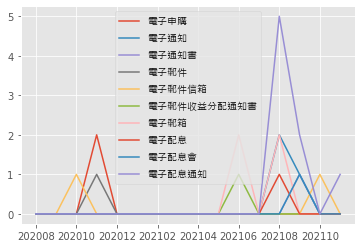

In [147]:
plt.figure(figsize=(20, 16))

df_duration_pivot.index = [str(item) for item in df_duration_pivot.index.tolist()]
df_duration_pivot.iloc[:, -100:-90].plot()
plt.legend(prop=fontproperties)
plt.show()



### 相似詞建模

- 多為短句
- 單一語料 

In [12]:
from gensim.models import word2vec
import gensim

In [42]:
df[(df['問法'].str.contains('信用卡')) & (df['問法'].str.contains(''))]

,file_date,問法,keyword,phrase,month,weekOfYear
824,20200928,信用卡,信用卡,信用卡,202009,20211004-20211010
1129,20201026,可以用信用卡買基金嗎?,"信用卡,買,基金","信用卡,基金",202010,20211101-20211107
2841,20201222,申請信用卡,"申請,信用卡",信用卡,202012,20211227-20220102
2842,20201222,信用卡,信用卡,信用卡,202012,20211227-20220102
4197,20210329,信用卡帳單,"信用卡,帳單",信用卡帳單,202103,20220328-20220403
5108,20210531,信用卡未出帳單,"信用卡,未,出帳單","帳單,信用卡",202105,20220530-20220605
6955,20210816,信用卡,信用卡,信用卡,202108,20220815-20220821
7094,20210816,何謂信用卡小數點?,"何謂,信用卡,小數點",信用卡小數點?,202108,20220815-20220821
7830,20210830,辦信用卡分期,"辦,信用卡",信用卡,202108,20220829-20220904
7929,20210906,信用卡金額,"信用卡,金額",信用卡金額,202109,20220905-20220911


In [49]:
kw_col = 'phrase'
afa_kw_corpus = list()

for row in df[kw_col].values.tolist():
    try:
        res = [item.strip() for item in row.split(',') if (item.strip() != '') and (len(item.strip()) > 1)]
        afa_kw_corpus.append(res)
    except:
        # print(row)
        # res = ['']
        pass

afa_kw_corpus_expand = list()
for row in afa_kw_corpus:
    for item in row:
        afa_kw_corpus_expand.append(item)

afa_kw_corpus_unique = np.unique(afa_kw_corpus_expand)
len(afa_kw_corpus_unique)


2841

In [87]:
# Settings
seed = 888
sgs = [1] #[0, 1]
window_sizes = [2] #[1, 2, 3, 4, 5]
vector_sizes = [300] #[50, 100, 300, 500, 1000, 2000]
min_count = 1
workers = 8
epochs = [50] #[30, 50, 100]


# with open(f'external_output/word2vec_models/logging-{kw_col}.txt', 'w', encoding='utf-8') as f:
#     f.write(f'parameters: \nseed: {seed}\nwindow_size: {window_size}\nmin_count: {min_count}\nworkers: {workers}\n\n')

for epoch in tqdm(epochs):
    for sg in tqdm(sgs):
        for window_size in tqdm(window_sizes):
            for vector_size in tqdm(vector_sizes):

                model = word2vec.Word2Vec(
                    afa_kw_corpus,  # 語料
                    min_count=min_count,  # 詞彙的最小頻率，小於則從語料中排除
                    vector_size=vector_size,  # 詞向量維度
                    workers=workers,  # 使用多少 worker threads 訓練模型
                    epochs=epoch,  # iterations on this corpus
                    window=window_size,  # 多遠之內的詞要納入相似判斷範圍
                    sg=sg,  # 0=CBOW, 1=skip-gram
                    seed=seed,  # 向量初始化所需的隨機亂數生成
                    shrink_windows=True
                )
                
                # with open(f'external_output/word2vec_models/logging-{kw_col}.txt', 'a', encoding='utf-8') as f:
                #     f.write(f'===== epoch: {epoch} & sg: {sg} & vector_size: {vector_size} ===== \n')
                #     for test_word in ['信用卡','Line']:
                #         f.write(f'test word: {test_word}\n')
                #         res = model.wv.most_similar(test_word)
                #         for item in res:
                #             f.write(str(item))
                #             f.write('\n')
                #         f.write('\n')
                #     f.write('\n')

model.save(f'external_output/word2vec/models/afa-{kw_col}-word2vec-epoch_{epoch}-sg_{sg}-vector_size_{vector_size}-window_size_{window_size}.model')


  0%|          | 0/1 [00:00<?, ?it/s]




100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


In [90]:
model = gensim.models.Word2Vec.load('external_output/word2vec/models/afa-phrase-word2vec-epoch_50-sg_1-vector_size_300-window_size_2.model')
# model.wv.most_similar('Line')


In [83]:
len(model.wv.key_to_index.keys())
# KeyedVectors


2841

In [88]:
list_of_rows = list()
similarity_dict = dict()

for k in tqdm(afa_kw_corpus_unique_counts.keys()):
    try:
        sim_words_with_prob = model.wv.most_similar(k, topn=100)
        list_of_rows += [(k, ) + item_set for item_set in sim_words_with_prob]
        similarity_dict.update({k: sim_words_with_prob})
    except:
        pass


word2vec_similarity_phrase = pd.DataFrame(list_of_rows, columns=['目標關鍵詞','相似關鍵詞','相似度'])
word2vec_similarity_phrase.to_csv(f'external_output/word2vec/word2vec_similarity-{kw_col}.csv', index=False)
# print(word2vec_similarity_phrase.shape)

with open(f'external_output/word2vec/word2vec_similarity-{kw_col}.json', 'w', encoding='utf-8') as f:
    json.dump(similarity_dict, f, ensure_ascii=False, indent=4)

del similarity_dict, word2vec_similarity_phrase


100%|██████████| 2841/2841 [00:02<00:00, 1182.88it/s]


### 關鍵詞共現統計

In [52]:
kw_concurrency = dict()

for kw in tqdm(afa_kw_corpus_unique):
    concurrent_words = list()
    for row in afa_kw_corpus_unique:
        if kw in row:
            concurrent_words += row
        else:
            pass
        
    concurrent_words = [word for word in concurrent_words if word != kw]
    concurrent_words = dict(Counter(concurrent_words))
    kw_concurrency.update({kw: concurrent_words})
    
    
len(kw_concurrency.keys())


100%|██████████| 2841/2841 [00:02<00:00, 1192.58it/s]


2841

In [53]:
afa_kw_corpus_unique_counts = dict(Counter(afa_kw_corpus_expand))
afa_kw_corpus_unique_counts = dict(sorted(afa_kw_corpus_unique_counts.items(), key=lambda k: k[1], reverse=True))
afa_kw_corpus_unique_counts


{'基金': 720,
 '國泰': 212,
 '手續費': 186,
 '定額': 160,
 '淨值': 155,
 'ETF': 149,
 '帳號': 139,
 '扣款': 136,
 '帳戶': 123,
 '阿發': 115,
 '密碼': 106,
 '國泰e家人': 95,
 '電子帳單': 76,
 '客服': 73,
 '5G': 73,
 '開戶進度': 62,
 '電動車': 58,
 '帳單': 54,
 '專人': 52,
 '線上': 49,
 '配息': 47,
 '資料': 45,
 '幹嘛': 44,
 '單筆': 42,
 '人生': 40,
 '扣款帳號': 38,
 '真人': 38,
 '客戶': 38,
 '國泰臺灣5G': 38,
 '申請書': 37,
 '基金淨值': 37,
 '股票': 37,
 '國泰一家人': 36,
 'e家人': 35,
 '扣款日': 33,
 '扣款帳戶': 33,
 '中國內需': 32,
 '國泰5G': 32,
 '績效': 31,
 '簡訊': 31,
 '金額': 31,
 '泰好': 31,
 '外幣': 30,
 '電話': 30,
 '網址': 30,
 '扣款日期': 28,
 '中國': 28,
 '銀行': 28,
 '手機': 27,
 '基金手續費': 26,
 '風險屬性': 26,
 '國泰國泰': 23,
 '國泰投信': 23,
 '國泰泰': 23,
 'ETF基金': 23,
 '交易': 22,
 '定額扣款': 22,
 '生日': 22,
 '定額手續費': 22,
 '加碼': 22,
 '高股息': 21,
 '地址': 21,
 '美元': 21,
 '基本資料': 20,
 '客服電話': 20,
 '國泰全球智慧電動車ETF': 20,
 '國泰臺灣高股息基金': 19,
 '差別': 19,
 '真人客服': 19,
 '時間': 19,
 '申購手續費': 19,
 '費用': 19,
 '集保帳號': 19,
 '科技': 18,
 '開戶': 18,
 '系列': 18,
 '紙本': 18,
 '外幣帳戶': 18,
 '點數': 18,
 '證券': 17,
 '家人': 17,
 '基金總覽': 17,
 '臺灣

In [274]:
kw_concurrency_sorted = dict()

for kw in tqdm(afa_kw_corpus_unique_counts.keys()):
    sorted_temp_dict = dict(sorted(kw_concurrency[kw].items(), key=lambda k: k[1], reverse=True))
    kw_concurrency_sorted.update({kw: sorted_temp_dict})



100%|██████████| 2782/2782 [00:00<00:00, 191099.80it/s]


In [276]:
kw_concurrency_sorted['信用卡']


{'基金': 3,
 '帳單': 3,
 '申請': 1,
 '出帳單': 1,
 '何謂': 1,
 '小數點': 1,
 '金額': 1,
 '停用': 1,
 '出帳': 1,
 '餘額': 1,
 '電子': 1,
 '取消': 1}

In [277]:
with open(f'external_output/cooccurrence/sorted_cooccurrence-{kw_col}.json', 'w', encoding='utf-8') as f:
    json.dump(kw_concurrency_sorted, f, ensure_ascii=False, indent=4)
